In [148]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import torch.nn.functional as F
from sklearn.neighbors import NearestNeighbors
from tqdm.auto import tqdm
from time import sleep
import torchvision
import torch_geometric.nn as pyg_nn
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score

cudnn.benchmark = True
plt.ion()   # interactive mode

In [149]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [150]:
features_covid = torch.load(r'covid.pt', map_location=torch.device('cpu'))
features_noncovid = torch.load(r'health.pt',map_location=torch.device('cpu'))

In [151]:
train_labels = torch.zeros((features_covid.shape[0]))
test_labels = torch.ones((features_noncovid.shape[0]))

In [152]:
features_covid.shape
train_labels.shape
len(test_labels)

1229

In [154]:
train_feats = []
train_label = []
for i in range(250,len(test_labels)):
    train_feats.append(features_covid[i])
    train_feats.append(features_noncovid[i])
    train_label.append(train_labels[i])
    train_label.append(test_labels[i])

In [155]:
len(train_feats)
len(train_label)

1958

In [156]:
test_feats = []
test_label = []

In [157]:
for i in range(0,250):
    test_feats.append(features_covid[i])
    test_feats.append(features_noncovid[i])
    test_label.append(train_labels[i])
    test_label.append(test_labels[i])

In [158]:
print(len(test_feats))
len(test_label)

500


500

In [159]:
train_feats = torch.stack(train_feats)
train_label = torch.stack(train_label)
test_feats = torch.stack(test_feats)
test_label = torch.stack(test_label)

In [160]:
print(train_feats.shape)
print(train_label.shape)
print(test_feats.shape)

torch.Size([1958, 128])
torch.Size([1958])
torch.Size([500, 128])


In [161]:
features_train = train_feats.unsqueeze(1)
features_test = test_feats.unsqueeze(1)

In [162]:
train_label = train_label.to(torch.long)
test_label = test_label.to(torch.long)

In [163]:
test_label

tensor([0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
        0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
        0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
        0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
        0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
        0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
        0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
        0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
        0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
        0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
        0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
        0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
        0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,

In [164]:
# Learning rate parameters
BASE_LR = 0.0001
EPOCH_DECAY = 5 # number of epochs after which the Learning rate is decayed exponentially.
DECAY_WEIGHT = 0.5 # factor by which the learning rate is reduced.


# DATASET INFO
NUM_CLASSES = 2 # set the number of classes in your dataset
VALID_SPLIT = 0.8

# DATALOADER PROPERTIES
BATCH_SIZE = 1024 # Set as high as possible. If you keep it too high, you'll get an out of memory error.

In [165]:
from torch.utils.data import Dataset, DataLoader

class FeatureDataset(Dataset):
  """
  This is a custom dataset class to generate feature dataset to load into models
  """
  def __init__(self, X, Y):
    features = []
    labels = []
    
    for i in range(0,X.shape[0]):
      temp = X[i]
      features.append(temp)
      s = torch.stack(features)
      self.X = s
      temp1 = Y[i]
      labels.append(temp1)
      t = torch.stack(labels)
      self.Y = t

    
    if len(self.X) != len(self.Y):
        raise Exception("The length of X does not match the length of Y")

  def __len__(self):
    return len(self.X)

  def __getitem__(self, index):
    # note that this isn't randomly selecting. It's a simple get a single item that represents an x and y
    x = self.X[index]
    y = self.Y[index]

    return x, y

In [166]:
#dataset for train and val
dataset = FeatureDataset(features_train, train_label)

print(dataset)


In [167]:
#dataset for test
test_data = FeatureDataset(features_test,test_label)
test_loader = DataLoader(test_data,batch_size=BATCH_SIZE,shuffle=True)
print(len(test_loader))

1


In [168]:
len(dataset)

1958

In [169]:
SIZE =0.8
a = int(SIZE * len(dataset))
b = len(dataset)- a
train_data, val_data = torch.utils.data.random_split(dataset,[a,b])
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE,shuffle=True)
print(len(train_loader),len(val_loader))

2 1


In [170]:
#k = 21

def nearestneighbours(features, k):
    neighbour = NearestNeighbors(n_neighbors=k)
    features = features.cpu().detach().numpy()
    features = features.squeeze()
    neighbour.fit(features)
    temp_matrix = neighbour.kneighbors_graph(features)
    temp_matrix = temp_matrix.toarray()
    temp_matrix = torch.from_numpy(temp_matrix)
    temp_matrix = temp_matrix.to(device)

    return temp_matrix

In [171]:
def edge_finder(matrix):
    matrix = matrix.cpu()
    m = matrix.numpy().squeeze()
    edge = []
    
    for i in range(0,matrix.shape[0]):
        for j in range(0,matrix.shape[0]):
            if(m[i][j] == 1):
                x = i,j
                edge.append(x)

    edge = np.array(edge)
    edge  = torch.from_numpy(edge)
    edge = edge.T
    edge = edge.to(torch.long) 
    edge = edge.to(device)   
    return(edge)

In [172]:
class SaveBestModel:
    """
    Class to save the best model while training. If the current epoch's 
    validation loss is less than the previous least less, then save the
    model state.
    """
    def __init__(
        self, best_valid_loss=float('inf')
    ):
        self.best_valid_loss = best_valid_loss
        
    def __call__(
        self, current_valid_loss, 
        epoch, model, optimizer, criterion
    ):
        if current_valid_loss < self.best_valid_loss:
            self.best_valid_loss = current_valid_loss
            print(f"\nBest validation loss: {self.best_valid_loss}")
            print(f"\nSaving best model for epoch: {epoch+1}\n")
            torch.save({
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                }, 'best_model_features.pth')

In [173]:
def save_model(epochs, model, optimizer, criterion):
    """
    Function to save the trained model to disk.
    """
    print(f"Saving final model...")
    torch.save({
                'epoch': epochs,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                }, 'final_model_features.pth')

In [174]:
def save_plots(train_acc, valid_acc, train_loss, valid_loss):
    """
    Function to save the loss and accuracy plots to disk.
    """
    # accuracy plots
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_acc, color='green', linestyle='dotted', 
        label='train accuracy'
    )
    plt.plot(
        valid_acc, color='blue', linestyle='dotted', 
        label='validataion accuracy'
    )
    #plt.ylim([60,100])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    
    plt.legend()
    plt.savefig('accuracy.png')
    
    # loss plots
    plt.figure(figsize=(10, 7))
    plt.plot(
        train_loss, color='orange', linestyle='dotted', 
        label='train loss'
    )
    plt.plot(
        valid_loss, color='red', linestyle='dotted', 
        label='validataion loss'
    )
    #plt.ylim([0,0.6])
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('loss.png')
    plt.show()

In [175]:
class GAT(torch.nn.Module):
  """Graph Attention Network"""
  def __init__(self, dim_in, dim_h, dim_out, heads=8):
    super().__init__()
    self.gat1 = pyg_nn.GATv2Conv(dim_in, dim_h, heads=heads)
    self.gat2 = pyg_nn.GATv2Conv(dim_h*heads, dim_out, heads=1)
    self.optimizer = torch.optim.Adam(self.parameters(),
                                      lr=0.005,
                                      weight_decay=5e-4)

  def forward(self, x, edge_index):
    h = F.dropout(x, p=0.6)
    h = self.gat1(x.float(), edge_index)
    h = F.elu(h)
    h = F.dropout(h, p=0.6)
    h = self.gat2(h, edge_index)
    return F.log_softmax(h, dim=1)


In [176]:
def accuracy(pred_y, y):
    """Calculate accuracy."""
    return ((pred_y == y).sum() / len(y)).item()

In [177]:
gat = GAT(features_train.shape[2], 64, NUM_CLASSES)
print(gat)

GAT(
  (gat1): GATv2Conv(128, 64, heads=8)
  (gat2): GATv2Conv(512, 2, heads=1)
)


In [178]:
model_gat = gat
model_gat = model_gat.to(device)
# optimizer
optimizer_gat = optim.Adam(model_gat.parameters(), lr=0.0001)
# loss function
criterion = nn.CrossEntropyLoss()
# total parameters and trainable parameters
total_params1 = sum(p.numel() for p in model_gat.parameters())
print(f"{total_params1:,} total parameters.")
# initialize SaveBestModel class
save_best_model = SaveBestModel()
print(model_gat)

135,176 total parameters.
GAT(
  (gat1): GATv2Conv(128, 64, heads=8)
  (gat2): GATv2Conv(512, 2, heads=1)
)


In [179]:
# training
def train(model, trainloader, optimizer, criterion, k):
    model.train()
    #print('Training')
    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0
    for i, data in tqdm(enumerate(trainloader), total=len(trainloader)):
        counter += 1
        features, labels = data
        features = features.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        # forward pass
        adj = nearestneighbours(features, k)
        edge = edge_finder(adj)
        out = model_gat(features.squeeze(), edge)
        label = labels.to(torch.long)
        loss = criterion(out, label)
        #acc = accuracy(out.argmax(dim=1), labels)
        #outputs = outputs.to(torch.long)
        #outputs = model(image)
        # calculate the loss
        train_running_loss += loss.item()
        # calculate the accuracy
        _, preds = torch.max(out, 1)
        train_running_correct += (preds == label).sum().item()
        # backpropagation
        loss.backward(retain_graph=True)
        # update the optimizer parameters
        optimizer.step()
    
    # loss and accuracy for the complete epoch
    epoch_loss = train_running_loss / counter
    epoch_acc = 100. * (train_running_correct / len(trainloader.dataset))
    return epoch_loss, epoch_acc

In [180]:
# validation
def validate(model, testloader, criterion,k):
    model.eval()
    #print('Validation')
    valid_running_loss = 0.0
    valid_running_correct = 0
    counter = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(testloader), total=len(testloader)):
            counter += 1
            features, labels = data
            features = features.to(device)
            labels = labels.to(device)
            # forward pass
            adj = nearestneighbours(features, k)
            edge = edge_finder(adj)
            out = model_gat(features.squeeze(), edge)
            label = labels.to(torch.long)
            loss = criterion(out, label)
            #outputs = model(image)
            # forward pass
            #outputs = model(features)
            # calculate the loss
            valid_running_loss += loss.item()
            # calculate the accuracy
            _, preds = torch.max(out, 1)
            valid_running_correct += (preds == label).sum().item()
        
    # loss and accuracy for the complete epoch
    epoch_loss = valid_running_loss / counter
    epoch_acc = 100. * (valid_running_correct / len(testloader.dataset))
    return epoch_loss, epoch_acc

In [181]:
def train_val(model_gat=model_gat, train_loader=train_loader,val_loader=val_loader, optimizer_gat=optimizer_gat, criterion=criterion, epochs=50):  
    # lists to keep track of losses and accuracies
    train_loss, valid_loss = [], []
    train_acc, valid_acc = [], []
    # start the training
    k_list = [3, 5, 11, 15, 21]
    for k in k_list:
        for epoch in range(epochs):
            print(f"[INFO]: Epoch {epoch+1} of {epochs}")
            #optimizer = exp_lr_scheduler(optimizer_ft, epochs)
            train_epoch_loss, train_epoch_acc = train(model_gat, train_loader,optimizer_gat, criterion, k)
            valid_epoch_loss, valid_epoch_acc = validate(model_gat, val_loader,criterion, k)
            train_loss.append(train_epoch_loss)
            valid_loss.append(valid_epoch_loss)
            train_acc.append(train_epoch_acc)
            valid_acc.append(valid_epoch_acc)  
            
            print(f"K: {k}, Training loss: {train_epoch_loss:.3f}, training acc: {train_epoch_acc:.3f}, epoch: {epoch}")
            print(f"K: {k}, Validation loss: {valid_epoch_loss:.3f}, validation acc: {valid_epoch_acc:.3f}, epoch: {epoch}")
                # save the best model till now if we have the least loss in the current epoch
            save_best_model(valid_epoch_loss, epoch, model_gat, optimizer_gat, criterion)
            print('-'*50)
        print('-'*50)
        
        # save the trained model weights for a final time
        save_model(epochs, model_gat, optimizer_gat, criterion)
        # save the loss and accuracy plots
        save_plots(train_acc, valid_acc, train_loss, valid_loss)
    print('TRAINING COMPLETE')

[INFO]: Epoch 1 of 50


100%|██████████| 1/1 [00:00<00:00,  5.26it/s]


K: 3, Training loss: 1.132, training acc: 48.148, epoch: 0
K: 3, Validation loss: 0.835, validation acc: 61.480, epoch: 0

Best validation loss: 0.8345412611961365

Saving best model for epoch: 1

--------------------------------------------------
[INFO]: Epoch 2 of 50


100%|██████████| 1/1 [00:00<00:00,  5.21it/s]


K: 3, Training loss: 0.797, training acc: 63.155, epoch: 1
K: 3, Validation loss: 0.581, validation acc: 75.255, epoch: 1

Best validation loss: 0.581470787525177

Saving best model for epoch: 2

--------------------------------------------------
[INFO]: Epoch 3 of 50


100%|██████████| 1/1 [00:00<00:00,  4.83it/s]


K: 3, Training loss: 0.464, training acc: 77.522, epoch: 2
K: 3, Validation loss: 0.453, validation acc: 80.867, epoch: 2

Best validation loss: 0.452752023935318

Saving best model for epoch: 3

--------------------------------------------------
[INFO]: Epoch 4 of 50


100%|██████████| 1/1 [00:00<00:00,  4.93it/s]


K: 3, Training loss: 0.328, training acc: 84.547, epoch: 3
K: 3, Validation loss: 0.305, validation acc: 89.031, epoch: 3

Best validation loss: 0.3045766055583954

Saving best model for epoch: 4

--------------------------------------------------
[INFO]: Epoch 5 of 50


100%|██████████| 1/1 [00:00<00:00,  5.95it/s]


K: 3, Training loss: 0.288, training acc: 89.719, epoch: 4
K: 3, Validation loss: 0.277, validation acc: 89.796, epoch: 4

Best validation loss: 0.2769581973552704

Saving best model for epoch: 5

--------------------------------------------------
[INFO]: Epoch 6 of 50


100%|██████████| 1/1 [00:00<00:00,  4.81it/s]


K: 3, Training loss: 0.249, training acc: 91.060, epoch: 5
K: 3, Validation loss: 0.261, validation acc: 90.816, epoch: 5

Best validation loss: 0.26109030842781067

Saving best model for epoch: 6

--------------------------------------------------
[INFO]: Epoch 7 of 50


100%|██████████| 1/1 [00:00<00:00,  4.78it/s]


K: 3, Training loss: 0.199, training acc: 92.593, epoch: 6
K: 3, Validation loss: 0.226, validation acc: 91.837, epoch: 6

Best validation loss: 0.226138174533844

Saving best model for epoch: 7

--------------------------------------------------
[INFO]: Epoch 8 of 50


100%|██████████| 1/1 [00:00<00:00,  5.39it/s]


K: 3, Training loss: 0.227, training acc: 92.465, epoch: 7
K: 3, Validation loss: 0.219, validation acc: 92.092, epoch: 7

Best validation loss: 0.21942751109600067

Saving best model for epoch: 8

--------------------------------------------------
[INFO]: Epoch 9 of 50


100%|██████████| 1/1 [00:00<00:00,  5.95it/s]


K: 3, Training loss: 0.224, training acc: 93.040, epoch: 8
K: 3, Validation loss: 0.221, validation acc: 92.092, epoch: 8
--------------------------------------------------
[INFO]: Epoch 10 of 50


100%|██████████| 1/1 [00:00<00:00,  5.42it/s]


K: 3, Training loss: 0.218, training acc: 93.614, epoch: 9
K: 3, Validation loss: 0.213, validation acc: 94.388, epoch: 9

Best validation loss: 0.21254776418209076

Saving best model for epoch: 10

--------------------------------------------------
[INFO]: Epoch 11 of 50


100%|██████████| 1/1 [00:00<00:00,  5.49it/s]


K: 3, Training loss: 0.224, training acc: 93.359, epoch: 10
K: 3, Validation loss: 0.208, validation acc: 91.837, epoch: 10

Best validation loss: 0.2083808183670044

Saving best model for epoch: 11

--------------------------------------------------
[INFO]: Epoch 12 of 50


100%|██████████| 1/1 [00:00<00:00,  5.21it/s]


K: 3, Training loss: 0.196, training acc: 93.806, epoch: 11
K: 3, Validation loss: 0.193, validation acc: 92.857, epoch: 11

Best validation loss: 0.19342246651649475

Saving best model for epoch: 12

--------------------------------------------------
[INFO]: Epoch 13 of 50


100%|██████████| 1/1 [00:00<00:00,  5.91it/s]


K: 3, Training loss: 0.223, training acc: 92.912, epoch: 12
K: 3, Validation loss: 0.211, validation acc: 92.092, epoch: 12
--------------------------------------------------
[INFO]: Epoch 14 of 50


100%|██████████| 1/1 [00:00<00:00,  4.56it/s]


K: 3, Training loss: 0.189, training acc: 93.487, epoch: 13
K: 3, Validation loss: 0.228, validation acc: 94.133, epoch: 13
--------------------------------------------------
[INFO]: Epoch 15 of 50


100%|██████████| 1/1 [00:00<00:00,  4.98it/s]


K: 3, Training loss: 0.204, training acc: 93.614, epoch: 14
K: 3, Validation loss: 0.208, validation acc: 93.112, epoch: 14
--------------------------------------------------
[INFO]: Epoch 16 of 50


100%|██████████| 1/1 [00:00<00:00,  5.43it/s]


K: 3, Training loss: 0.195, training acc: 93.487, epoch: 15
K: 3, Validation loss: 0.188, validation acc: 92.602, epoch: 15

Best validation loss: 0.18792936205863953

Saving best model for epoch: 16

--------------------------------------------------
[INFO]: Epoch 17 of 50


100%|██████████| 1/1 [00:00<00:00,  5.44it/s]


K: 3, Training loss: 0.186, training acc: 94.444, epoch: 16
K: 3, Validation loss: 0.193, validation acc: 92.092, epoch: 16
--------------------------------------------------
[INFO]: Epoch 18 of 50


100%|██████████| 1/1 [00:00<00:00,  5.00it/s]


K: 3, Training loss: 0.211, training acc: 93.997, epoch: 17
K: 3, Validation loss: 0.166, validation acc: 94.898, epoch: 17

Best validation loss: 0.16589359939098358

Saving best model for epoch: 18

--------------------------------------------------
[INFO]: Epoch 19 of 50


100%|██████████| 1/1 [00:00<00:00,  5.24it/s]


K: 3, Training loss: 0.197, training acc: 93.167, epoch: 18
K: 3, Validation loss: 0.183, validation acc: 93.622, epoch: 18
--------------------------------------------------
[INFO]: Epoch 20 of 50


100%|██████████| 1/1 [00:00<00:00,  4.63it/s]


K: 3, Training loss: 0.198, training acc: 93.678, epoch: 19
K: 3, Validation loss: 0.184, validation acc: 92.602, epoch: 19
--------------------------------------------------
[INFO]: Epoch 21 of 50


100%|██████████| 1/1 [00:00<00:00,  5.17it/s]


K: 3, Training loss: 0.221, training acc: 93.678, epoch: 20
K: 3, Validation loss: 0.195, validation acc: 94.133, epoch: 20
--------------------------------------------------
[INFO]: Epoch 22 of 50


100%|██████████| 1/1 [00:00<00:00,  4.44it/s]


K: 3, Training loss: 0.185, training acc: 93.423, epoch: 21
K: 3, Validation loss: 0.209, validation acc: 93.112, epoch: 21
--------------------------------------------------
[INFO]: Epoch 23 of 50


100%|██████████| 1/1 [00:00<00:00,  4.98it/s]


K: 3, Training loss: 0.230, training acc: 93.997, epoch: 22
K: 3, Validation loss: 0.181, validation acc: 92.092, epoch: 22
--------------------------------------------------
[INFO]: Epoch 24 of 50


100%|██████████| 1/1 [00:00<00:00,  3.37it/s]


K: 3, Training loss: 0.167, training acc: 93.997, epoch: 23
K: 3, Validation loss: 0.189, validation acc: 92.347, epoch: 23
--------------------------------------------------
[INFO]: Epoch 25 of 50


100%|██████████| 1/1 [00:00<00:00,  4.17it/s]


K: 3, Training loss: 0.181, training acc: 93.423, epoch: 24
K: 3, Validation loss: 0.179, validation acc: 94.643, epoch: 24
--------------------------------------------------
[INFO]: Epoch 26 of 50


100%|██████████| 1/1 [00:00<00:00,  4.89it/s]


K: 3, Training loss: 0.172, training acc: 94.317, epoch: 25
K: 3, Validation loss: 0.158, validation acc: 94.133, epoch: 25

Best validation loss: 0.15798769891262054

Saving best model for epoch: 26

--------------------------------------------------
[INFO]: Epoch 27 of 50


100%|██████████| 1/1 [00:00<00:00,  4.81it/s]


K: 3, Training loss: 0.212, training acc: 94.317, epoch: 26
K: 3, Validation loss: 0.177, validation acc: 93.367, epoch: 26
--------------------------------------------------
[INFO]: Epoch 28 of 50


100%|██████████| 1/1 [00:00<00:00,  3.75it/s]


K: 3, Training loss: 0.189, training acc: 93.678, epoch: 27
K: 3, Validation loss: 0.214, validation acc: 93.878, epoch: 27
--------------------------------------------------
[INFO]: Epoch 29 of 50


100%|██████████| 1/1 [00:00<00:00,  3.87it/s]


K: 3, Training loss: 0.166, training acc: 94.572, epoch: 28
K: 3, Validation loss: 0.189, validation acc: 91.837, epoch: 28
--------------------------------------------------
[INFO]: Epoch 30 of 50


100%|██████████| 1/1 [00:00<00:00,  3.68it/s]


K: 3, Training loss: 0.177, training acc: 94.508, epoch: 29
K: 3, Validation loss: 0.175, validation acc: 93.367, epoch: 29
--------------------------------------------------
[INFO]: Epoch 31 of 50


100%|██████████| 1/1 [00:00<00:00,  4.17it/s]


K: 3, Training loss: 0.202, training acc: 93.550, epoch: 30
K: 3, Validation loss: 0.163, validation acc: 93.112, epoch: 30
--------------------------------------------------
[INFO]: Epoch 32 of 50


100%|██████████| 1/1 [00:00<00:00,  5.22it/s]


K: 3, Training loss: 0.174, training acc: 93.870, epoch: 31
K: 3, Validation loss: 0.173, validation acc: 93.112, epoch: 31
--------------------------------------------------
[INFO]: Epoch 33 of 50


100%|██████████| 1/1 [00:00<00:00,  5.75it/s]


K: 3, Training loss: 0.149, training acc: 95.275, epoch: 32
K: 3, Validation loss: 0.167, validation acc: 94.643, epoch: 32
--------------------------------------------------
[INFO]: Epoch 34 of 50


100%|██████████| 1/1 [00:00<00:00,  5.92it/s]


K: 3, Training loss: 0.176, training acc: 93.678, epoch: 33
K: 3, Validation loss: 0.200, validation acc: 93.112, epoch: 33
--------------------------------------------------
[INFO]: Epoch 35 of 50


100%|██████████| 1/1 [00:00<00:00,  5.49it/s]


K: 3, Training loss: 0.151, training acc: 94.444, epoch: 34
K: 3, Validation loss: 0.180, validation acc: 94.388, epoch: 34
--------------------------------------------------
[INFO]: Epoch 36 of 50


100%|██████████| 1/1 [00:00<00:00,  4.97it/s]


K: 3, Training loss: 0.166, training acc: 94.253, epoch: 35
K: 3, Validation loss: 0.176, validation acc: 91.837, epoch: 35
--------------------------------------------------
[INFO]: Epoch 37 of 50


100%|██████████| 1/1 [00:00<00:00,  3.99it/s]


K: 3, Training loss: 0.191, training acc: 92.912, epoch: 36
K: 3, Validation loss: 0.181, validation acc: 93.622, epoch: 36
--------------------------------------------------
[INFO]: Epoch 38 of 50


100%|██████████| 1/1 [00:00<00:00,  4.17it/s]


K: 3, Training loss: 0.170, training acc: 93.997, epoch: 37
K: 3, Validation loss: 0.154, validation acc: 94.388, epoch: 37

Best validation loss: 0.15435265004634857

Saving best model for epoch: 38

--------------------------------------------------
[INFO]: Epoch 39 of 50


100%|██████████| 1/1 [00:00<00:00,  5.20it/s]


K: 3, Training loss: 0.163, training acc: 93.997, epoch: 38
K: 3, Validation loss: 0.178, validation acc: 93.367, epoch: 38
--------------------------------------------------
[INFO]: Epoch 40 of 50


100%|██████████| 1/1 [00:00<00:00,  5.00it/s]


K: 3, Training loss: 0.180, training acc: 93.934, epoch: 39
K: 3, Validation loss: 0.159, validation acc: 93.878, epoch: 39
--------------------------------------------------
[INFO]: Epoch 41 of 50


100%|██████████| 1/1 [00:00<00:00,  5.46it/s]


K: 3, Training loss: 0.163, training acc: 94.317, epoch: 40
K: 3, Validation loss: 0.187, validation acc: 92.857, epoch: 40
--------------------------------------------------
[INFO]: Epoch 42 of 50


100%|██████████| 1/1 [00:00<00:00,  5.19it/s]


K: 3, Training loss: 0.168, training acc: 94.572, epoch: 41
K: 3, Validation loss: 0.200, validation acc: 92.602, epoch: 41
--------------------------------------------------
[INFO]: Epoch 43 of 50


100%|██████████| 1/1 [00:00<00:00,  5.47it/s]


K: 3, Training loss: 0.161, training acc: 94.508, epoch: 42
K: 3, Validation loss: 0.156, validation acc: 94.133, epoch: 42
--------------------------------------------------
[INFO]: Epoch 44 of 50


100%|██████████| 1/1 [00:00<00:00,  4.09it/s]


K: 3, Training loss: 0.151, training acc: 94.253, epoch: 43
K: 3, Validation loss: 0.176, validation acc: 94.133, epoch: 43
--------------------------------------------------
[INFO]: Epoch 45 of 50


100%|██████████| 1/1 [00:00<00:00,  4.60it/s]


K: 3, Training loss: 0.193, training acc: 93.550, epoch: 44
K: 3, Validation loss: 0.191, validation acc: 91.837, epoch: 44
--------------------------------------------------
[INFO]: Epoch 46 of 50


100%|██████████| 1/1 [00:00<00:00,  5.78it/s]


K: 3, Training loss: 0.180, training acc: 93.870, epoch: 45
K: 3, Validation loss: 0.187, validation acc: 93.367, epoch: 45
--------------------------------------------------
[INFO]: Epoch 47 of 50


100%|██████████| 1/1 [00:00<00:00,  5.66it/s]


K: 3, Training loss: 0.153, training acc: 94.381, epoch: 46
K: 3, Validation loss: 0.166, validation acc: 92.347, epoch: 46
--------------------------------------------------
[INFO]: Epoch 48 of 50


100%|██████████| 1/1 [00:00<00:00,  5.48it/s]


K: 3, Training loss: 0.193, training acc: 93.870, epoch: 47
K: 3, Validation loss: 0.187, validation acc: 93.367, epoch: 47
--------------------------------------------------
[INFO]: Epoch 49 of 50


100%|██████████| 1/1 [00:00<00:00,  5.68it/s]


K: 3, Training loss: 0.203, training acc: 93.806, epoch: 48
K: 3, Validation loss: 0.160, validation acc: 93.878, epoch: 48
--------------------------------------------------
[INFO]: Epoch 50 of 50


100%|██████████| 1/1 [00:00<00:00,  4.86it/s]


K: 3, Training loss: 0.164, training acc: 94.828, epoch: 49
K: 3, Validation loss: 0.170, validation acc: 92.857, epoch: 49
--------------------------------------------------
--------------------------------------------------
Saving final model...


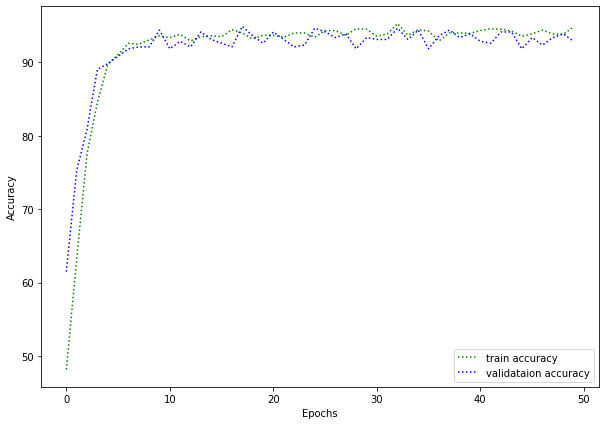

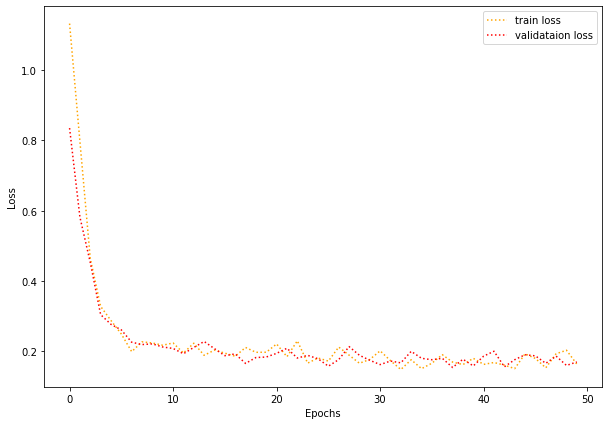

[INFO]: Epoch 1 of 50


100%|██████████| 1/1 [00:00<00:00,  4.91it/s]


K: 5, Training loss: 0.166, training acc: 94.189, epoch: 0
K: 5, Validation loss: 0.165, validation acc: 95.663, epoch: 0
--------------------------------------------------
[INFO]: Epoch 2 of 50


100%|██████████| 1/1 [00:00<00:00,  4.10it/s]


K: 5, Training loss: 0.168, training acc: 93.806, epoch: 1
K: 5, Validation loss: 0.164, validation acc: 94.133, epoch: 1
--------------------------------------------------
[INFO]: Epoch 3 of 50


100%|██████████| 1/1 [00:00<00:00,  5.05it/s]


K: 5, Training loss: 0.150, training acc: 93.997, epoch: 2
K: 5, Validation loss: 0.174, validation acc: 93.622, epoch: 2
--------------------------------------------------
[INFO]: Epoch 4 of 50


100%|██████████| 1/1 [00:00<00:00,  3.79it/s]


K: 5, Training loss: 0.165, training acc: 94.061, epoch: 3
K: 5, Validation loss: 0.204, validation acc: 92.092, epoch: 3
--------------------------------------------------
[INFO]: Epoch 5 of 50


100%|██████████| 1/1 [00:00<00:00,  5.21it/s]


K: 5, Training loss: 0.144, training acc: 94.764, epoch: 4
K: 5, Validation loss: 0.176, validation acc: 93.112, epoch: 4
--------------------------------------------------
[INFO]: Epoch 6 of 50


100%|██████████| 1/1 [00:00<00:00,  5.21it/s]


K: 5, Training loss: 0.169, training acc: 93.742, epoch: 5
K: 5, Validation loss: 0.171, validation acc: 94.898, epoch: 5
--------------------------------------------------
[INFO]: Epoch 7 of 50


100%|██████████| 1/1 [00:00<00:00,  3.57it/s]


K: 5, Training loss: 0.182, training acc: 93.423, epoch: 6
K: 5, Validation loss: 0.186, validation acc: 93.878, epoch: 6
--------------------------------------------------
[INFO]: Epoch 8 of 50


100%|██████████| 1/1 [00:00<00:00,  4.03it/s]


K: 5, Training loss: 0.160, training acc: 93.870, epoch: 7
K: 5, Validation loss: 0.172, validation acc: 94.643, epoch: 7
--------------------------------------------------
[INFO]: Epoch 9 of 50


100%|██████████| 1/1 [00:00<00:00,  4.03it/s]


K: 5, Training loss: 0.167, training acc: 94.636, epoch: 8
K: 5, Validation loss: 0.185, validation acc: 93.367, epoch: 8
--------------------------------------------------
[INFO]: Epoch 10 of 50


100%|██████████| 1/1 [00:00<00:00,  4.03it/s]


K: 5, Training loss: 0.175, training acc: 94.253, epoch: 9
K: 5, Validation loss: 0.177, validation acc: 93.112, epoch: 9
--------------------------------------------------
[INFO]: Epoch 11 of 50


100%|██████████| 1/1 [00:00<00:00,  5.68it/s]


K: 5, Training loss: 0.160, training acc: 94.508, epoch: 10
K: 5, Validation loss: 0.152, validation acc: 93.878, epoch: 10

Best validation loss: 0.152107834815979

Saving best model for epoch: 11

--------------------------------------------------
[INFO]: Epoch 12 of 50


100%|██████████| 1/1 [00:00<00:00,  5.80it/s]


K: 5, Training loss: 0.154, training acc: 94.317, epoch: 11
K: 5, Validation loss: 0.197, validation acc: 93.112, epoch: 11
--------------------------------------------------
[INFO]: Epoch 13 of 50


100%|██████████| 1/1 [00:00<00:00,  4.00it/s]


K: 5, Training loss: 0.159, training acc: 93.997, epoch: 12
K: 5, Validation loss: 0.166, validation acc: 95.153, epoch: 12
--------------------------------------------------
[INFO]: Epoch 14 of 50


100%|██████████| 1/1 [00:00<00:00,  5.70it/s]


K: 5, Training loss: 0.151, training acc: 94.955, epoch: 13
K: 5, Validation loss: 0.163, validation acc: 93.112, epoch: 13
--------------------------------------------------
[INFO]: Epoch 15 of 50


100%|██████████| 1/1 [00:00<00:00,  5.15it/s]


K: 5, Training loss: 0.154, training acc: 94.381, epoch: 14
K: 5, Validation loss: 0.156, validation acc: 94.898, epoch: 14
--------------------------------------------------
[INFO]: Epoch 16 of 50


100%|██████████| 1/1 [00:00<00:00,  5.33it/s]


K: 5, Training loss: 0.174, training acc: 93.423, epoch: 15
K: 5, Validation loss: 0.164, validation acc: 92.857, epoch: 15
--------------------------------------------------
[INFO]: Epoch 17 of 50


100%|██████████| 1/1 [00:00<00:00,  5.38it/s]


K: 5, Training loss: 0.159, training acc: 94.508, epoch: 16
K: 5, Validation loss: 0.141, validation acc: 93.878, epoch: 16

Best validation loss: 0.14068065583705902

Saving best model for epoch: 17

--------------------------------------------------
[INFO]: Epoch 18 of 50


100%|██████████| 1/1 [00:00<00:00,  4.77it/s]


K: 5, Training loss: 0.142, training acc: 94.955, epoch: 17
K: 5, Validation loss: 0.180, validation acc: 93.878, epoch: 17
--------------------------------------------------
[INFO]: Epoch 19 of 50


100%|██████████| 1/1 [00:00<00:00,  5.00it/s]


K: 5, Training loss: 0.165, training acc: 93.359, epoch: 18
K: 5, Validation loss: 0.178, validation acc: 93.367, epoch: 18
--------------------------------------------------
[INFO]: Epoch 20 of 50


100%|██████████| 1/1 [00:00<00:00,  5.21it/s]


K: 5, Training loss: 0.157, training acc: 94.317, epoch: 19
K: 5, Validation loss: 0.156, validation acc: 93.622, epoch: 19
--------------------------------------------------
[INFO]: Epoch 21 of 50


100%|██████████| 1/1 [00:00<00:00,  4.77it/s]


K: 5, Training loss: 0.162, training acc: 94.061, epoch: 20
K: 5, Validation loss: 0.165, validation acc: 94.133, epoch: 20
--------------------------------------------------
[INFO]: Epoch 22 of 50


100%|██████████| 1/1 [00:00<00:00,  5.21it/s]


K: 5, Training loss: 0.172, training acc: 94.891, epoch: 21
K: 5, Validation loss: 0.137, validation acc: 95.153, epoch: 21

Best validation loss: 0.1367480307817459

Saving best model for epoch: 22

--------------------------------------------------
[INFO]: Epoch 23 of 50


100%|██████████| 1/1 [00:00<00:00,  5.16it/s]


K: 5, Training loss: 0.158, training acc: 94.444, epoch: 22
K: 5, Validation loss: 0.155, validation acc: 95.918, epoch: 22
--------------------------------------------------
[INFO]: Epoch 24 of 50


100%|██████████| 1/1 [00:00<00:00,  5.43it/s]


K: 5, Training loss: 0.167, training acc: 94.700, epoch: 23
K: 5, Validation loss: 0.183, validation acc: 93.622, epoch: 23
--------------------------------------------------
[INFO]: Epoch 25 of 50


100%|██████████| 1/1 [00:00<00:00,  4.45it/s]


K: 5, Training loss: 0.147, training acc: 95.019, epoch: 24
K: 5, Validation loss: 0.156, validation acc: 95.153, epoch: 24
--------------------------------------------------
[INFO]: Epoch 26 of 50


100%|██████████| 1/1 [00:00<00:00,  4.73it/s]


K: 5, Training loss: 0.172, training acc: 93.870, epoch: 25
K: 5, Validation loss: 0.160, validation acc: 94.643, epoch: 25
--------------------------------------------------
[INFO]: Epoch 27 of 50


100%|██████████| 1/1 [00:00<00:00,  5.21it/s]


K: 5, Training loss: 0.168, training acc: 93.487, epoch: 26
K: 5, Validation loss: 0.191, validation acc: 93.112, epoch: 26
--------------------------------------------------
[INFO]: Epoch 28 of 50


100%|██████████| 1/1 [00:00<00:00,  5.00it/s]


K: 5, Training loss: 0.156, training acc: 94.636, epoch: 27
K: 5, Validation loss: 0.171, validation acc: 93.878, epoch: 27
--------------------------------------------------
[INFO]: Epoch 29 of 50


100%|██████████| 1/1 [00:00<00:00,  5.18it/s]


K: 5, Training loss: 0.153, training acc: 93.934, epoch: 28
K: 5, Validation loss: 0.170, validation acc: 93.622, epoch: 28
--------------------------------------------------
[INFO]: Epoch 30 of 50


100%|██████████| 1/1 [00:00<00:00,  5.00it/s]


K: 5, Training loss: 0.184, training acc: 94.061, epoch: 29
K: 5, Validation loss: 0.171, validation acc: 93.112, epoch: 29
--------------------------------------------------
[INFO]: Epoch 31 of 50


100%|██████████| 1/1 [00:00<00:00,  5.40it/s]


K: 5, Training loss: 0.170, training acc: 94.125, epoch: 30
K: 5, Validation loss: 0.175, validation acc: 93.367, epoch: 30
--------------------------------------------------
[INFO]: Epoch 32 of 50


100%|██████████| 1/1 [00:00<00:00,  4.79it/s]


K: 5, Training loss: 0.162, training acc: 94.891, epoch: 31
K: 5, Validation loss: 0.169, validation acc: 93.112, epoch: 31
--------------------------------------------------
[INFO]: Epoch 33 of 50


100%|██████████| 1/1 [00:00<00:00,  5.43it/s]


K: 5, Training loss: 0.150, training acc: 94.764, epoch: 32
K: 5, Validation loss: 0.156, validation acc: 94.388, epoch: 32
--------------------------------------------------
[INFO]: Epoch 34 of 50


100%|██████████| 1/1 [00:00<00:00,  5.41it/s]


K: 5, Training loss: 0.158, training acc: 94.253, epoch: 33
K: 5, Validation loss: 0.186, validation acc: 94.133, epoch: 33
--------------------------------------------------
[INFO]: Epoch 35 of 50


100%|██████████| 1/1 [00:00<00:00,  4.43it/s]


K: 5, Training loss: 0.159, training acc: 94.508, epoch: 34
K: 5, Validation loss: 0.139, validation acc: 94.133, epoch: 34
--------------------------------------------------
[INFO]: Epoch 36 of 50


100%|██████████| 1/1 [00:00<00:00,  4.46it/s]


K: 5, Training loss: 0.189, training acc: 93.997, epoch: 35
K: 5, Validation loss: 0.151, validation acc: 93.878, epoch: 35
--------------------------------------------------
[INFO]: Epoch 37 of 50


100%|██████████| 1/1 [00:00<00:00,  5.21it/s]


K: 5, Training loss: 0.175, training acc: 94.572, epoch: 36
K: 5, Validation loss: 0.173, validation acc: 93.112, epoch: 36
--------------------------------------------------
[INFO]: Epoch 38 of 50


100%|██████████| 1/1 [00:00<00:00,  5.34it/s]


K: 5, Training loss: 0.172, training acc: 94.317, epoch: 37
K: 5, Validation loss: 0.193, validation acc: 91.327, epoch: 37
--------------------------------------------------
[INFO]: Epoch 39 of 50


100%|██████████| 1/1 [00:00<00:00,  4.81it/s]


K: 5, Training loss: 0.154, training acc: 94.764, epoch: 38
K: 5, Validation loss: 0.148, validation acc: 93.622, epoch: 38
--------------------------------------------------
[INFO]: Epoch 40 of 50


100%|██████████| 1/1 [00:00<00:00,  5.43it/s]


K: 5, Training loss: 0.157, training acc: 94.061, epoch: 39
K: 5, Validation loss: 0.193, validation acc: 93.112, epoch: 39
--------------------------------------------------
[INFO]: Epoch 41 of 50


100%|██████████| 1/1 [00:00<00:00,  5.21it/s]


K: 5, Training loss: 0.139, training acc: 94.828, epoch: 40
K: 5, Validation loss: 0.165, validation acc: 93.367, epoch: 40
--------------------------------------------------
[INFO]: Epoch 42 of 50


100%|██████████| 1/1 [00:00<00:00,  5.43it/s]


K: 5, Training loss: 0.163, training acc: 94.189, epoch: 41
K: 5, Validation loss: 0.132, validation acc: 93.367, epoch: 41

Best validation loss: 0.13207097351551056

Saving best model for epoch: 42

--------------------------------------------------
[INFO]: Epoch 43 of 50


100%|██████████| 1/1 [00:00<00:00,  5.17it/s]


K: 5, Training loss: 0.148, training acc: 94.891, epoch: 42
K: 5, Validation loss: 0.170, validation acc: 93.878, epoch: 42
--------------------------------------------------
[INFO]: Epoch 44 of 50


100%|██████████| 1/1 [00:00<00:00,  4.79it/s]


K: 5, Training loss: 0.148, training acc: 93.997, epoch: 43
K: 5, Validation loss: 0.172, validation acc: 93.878, epoch: 43
--------------------------------------------------
[INFO]: Epoch 45 of 50


100%|██████████| 1/1 [00:00<00:00,  5.43it/s]


K: 5, Training loss: 0.155, training acc: 94.828, epoch: 44
K: 5, Validation loss: 0.154, validation acc: 95.153, epoch: 44
--------------------------------------------------
[INFO]: Epoch 46 of 50


100%|██████████| 1/1 [00:00<00:00,  5.15it/s]


K: 5, Training loss: 0.154, training acc: 94.891, epoch: 45
K: 5, Validation loss: 0.191, validation acc: 93.112, epoch: 45
--------------------------------------------------
[INFO]: Epoch 47 of 50


100%|██████████| 1/1 [00:00<00:00,  4.74it/s]


K: 5, Training loss: 0.145, training acc: 94.636, epoch: 46
K: 5, Validation loss: 0.140, validation acc: 94.898, epoch: 46
--------------------------------------------------
[INFO]: Epoch 48 of 50


100%|██████████| 1/1 [00:00<00:00,  5.91it/s]


K: 5, Training loss: 0.175, training acc: 94.700, epoch: 47
K: 5, Validation loss: 0.191, validation acc: 93.878, epoch: 47
--------------------------------------------------
[INFO]: Epoch 49 of 50


100%|██████████| 1/1 [00:00<00:00,  4.61it/s]


K: 5, Training loss: 0.158, training acc: 93.934, epoch: 48
K: 5, Validation loss: 0.171, validation acc: 93.878, epoch: 48
--------------------------------------------------
[INFO]: Epoch 50 of 50


100%|██████████| 1/1 [00:00<00:00,  4.96it/s]


K: 5, Training loss: 0.147, training acc: 94.444, epoch: 49
K: 5, Validation loss: 0.176, validation acc: 94.643, epoch: 49
--------------------------------------------------
--------------------------------------------------
Saving final model...


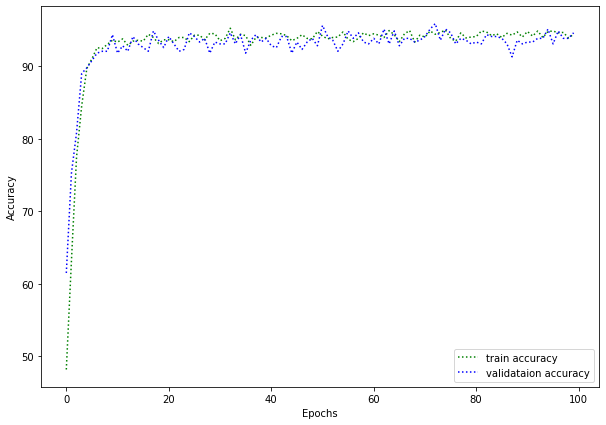

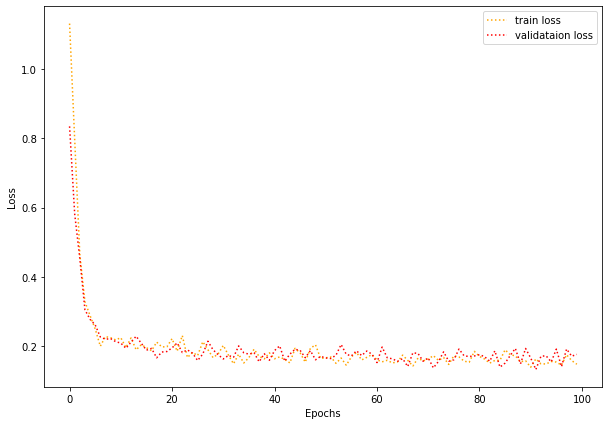

[INFO]: Epoch 1 of 50


100%|██████████| 1/1 [00:00<00:00,  4.28it/s]


K: 11, Training loss: 0.177, training acc: 93.487, epoch: 0
K: 11, Validation loss: 0.161, validation acc: 93.878, epoch: 0
--------------------------------------------------
[INFO]: Epoch 2 of 50


100%|██████████| 1/1 [00:00<00:00,  4.62it/s]


K: 11, Training loss: 0.187, training acc: 92.912, epoch: 1
K: 11, Validation loss: 0.154, validation acc: 93.878, epoch: 1
--------------------------------------------------
[INFO]: Epoch 3 of 50


100%|██████████| 1/1 [00:00<00:00,  4.27it/s]


K: 11, Training loss: 0.165, training acc: 93.359, epoch: 2
K: 11, Validation loss: 0.190, validation acc: 93.112, epoch: 2
--------------------------------------------------
[INFO]: Epoch 4 of 50


100%|██████████| 1/1 [00:00<00:00,  4.07it/s]


K: 11, Training loss: 0.217, training acc: 92.656, epoch: 3
K: 11, Validation loss: 0.144, validation acc: 93.622, epoch: 3
--------------------------------------------------
[INFO]: Epoch 5 of 50


100%|██████████| 1/1 [00:00<00:00,  4.14it/s]


K: 11, Training loss: 0.162, training acc: 94.061, epoch: 4
K: 11, Validation loss: 0.155, validation acc: 93.622, epoch: 4
--------------------------------------------------
[INFO]: Epoch 6 of 50


100%|██████████| 1/1 [00:00<00:00,  4.17it/s]


K: 11, Training loss: 0.164, training acc: 94.508, epoch: 5
K: 11, Validation loss: 0.204, validation acc: 93.112, epoch: 5
--------------------------------------------------
[INFO]: Epoch 7 of 50


100%|██████████| 1/1 [00:00<00:00,  4.12it/s]


K: 11, Training loss: 0.165, training acc: 94.572, epoch: 6
K: 11, Validation loss: 0.158, validation acc: 93.622, epoch: 6
--------------------------------------------------
[INFO]: Epoch 8 of 50


100%|██████████| 1/1 [00:00<00:00,  4.00it/s]


K: 11, Training loss: 0.156, training acc: 94.508, epoch: 7
K: 11, Validation loss: 0.160, validation acc: 93.112, epoch: 7
--------------------------------------------------
[INFO]: Epoch 9 of 50


100%|██████████| 1/1 [00:00<00:00,  4.44it/s]


K: 11, Training loss: 0.169, training acc: 94.253, epoch: 8
K: 11, Validation loss: 0.133, validation acc: 94.388, epoch: 8
--------------------------------------------------
[INFO]: Epoch 10 of 50


100%|██████████| 1/1 [00:00<00:00,  4.27it/s]


K: 11, Training loss: 0.158, training acc: 94.700, epoch: 9
K: 11, Validation loss: 0.162, validation acc: 92.092, epoch: 9
--------------------------------------------------
[INFO]: Epoch 11 of 50


100%|██████████| 1/1 [00:00<00:00,  4.28it/s]


K: 11, Training loss: 0.156, training acc: 94.508, epoch: 10
K: 11, Validation loss: 0.143, validation acc: 94.133, epoch: 10
--------------------------------------------------
[INFO]: Epoch 12 of 50


100%|██████████| 1/1 [00:00<00:00,  4.28it/s]


K: 11, Training loss: 0.160, training acc: 94.061, epoch: 11
K: 11, Validation loss: 0.166, validation acc: 93.622, epoch: 11
--------------------------------------------------
[INFO]: Epoch 13 of 50


100%|██████████| 1/1 [00:00<00:00,  4.02it/s]


K: 11, Training loss: 0.139, training acc: 94.955, epoch: 12
K: 11, Validation loss: 0.178, validation acc: 94.388, epoch: 12
--------------------------------------------------
[INFO]: Epoch 14 of 50


100%|██████████| 1/1 [00:00<00:00,  3.95it/s]


K: 11, Training loss: 0.163, training acc: 93.934, epoch: 13
K: 11, Validation loss: 0.159, validation acc: 94.643, epoch: 13
--------------------------------------------------
[INFO]: Epoch 15 of 50


100%|██████████| 1/1 [00:00<00:00,  4.32it/s]


K: 11, Training loss: 0.156, training acc: 94.508, epoch: 14
K: 11, Validation loss: 0.166, validation acc: 93.878, epoch: 14
--------------------------------------------------
[INFO]: Epoch 16 of 50


100%|██████████| 1/1 [00:00<00:00,  4.12it/s]


K: 11, Training loss: 0.160, training acc: 94.317, epoch: 15
K: 11, Validation loss: 0.178, validation acc: 93.112, epoch: 15
--------------------------------------------------
[INFO]: Epoch 17 of 50


100%|██████████| 1/1 [00:00<00:00,  4.01it/s]


K: 11, Training loss: 0.155, training acc: 94.955, epoch: 16
K: 11, Validation loss: 0.154, validation acc: 93.112, epoch: 16
--------------------------------------------------
[INFO]: Epoch 18 of 50


100%|██████████| 1/1 [00:00<00:00,  4.61it/s]


K: 11, Training loss: 0.171, training acc: 94.253, epoch: 17
K: 11, Validation loss: 0.152, validation acc: 93.622, epoch: 17
--------------------------------------------------
[INFO]: Epoch 19 of 50


100%|██████████| 1/1 [00:00<00:00,  4.13it/s]


K: 11, Training loss: 0.154, training acc: 94.764, epoch: 18
K: 11, Validation loss: 0.184, validation acc: 93.622, epoch: 18
--------------------------------------------------
[INFO]: Epoch 20 of 50


100%|██████████| 1/1 [00:00<00:00,  4.44it/s]


K: 11, Training loss: 0.151, training acc: 94.317, epoch: 19
K: 11, Validation loss: 0.149, validation acc: 94.133, epoch: 19
--------------------------------------------------
[INFO]: Epoch 21 of 50


100%|██████████| 1/1 [00:00<00:00,  4.29it/s]


K: 11, Training loss: 0.143, training acc: 95.147, epoch: 20
K: 11, Validation loss: 0.152, validation acc: 94.388, epoch: 20
--------------------------------------------------
[INFO]: Epoch 22 of 50


100%|██████████| 1/1 [00:00<00:00,  3.83it/s]


K: 11, Training loss: 0.153, training acc: 94.636, epoch: 21
K: 11, Validation loss: 0.151, validation acc: 95.153, epoch: 21
--------------------------------------------------
[INFO]: Epoch 23 of 50


100%|██████████| 1/1 [00:00<00:00,  3.69it/s]


K: 11, Training loss: 0.152, training acc: 95.211, epoch: 22
K: 11, Validation loss: 0.175, validation acc: 93.367, epoch: 22
--------------------------------------------------
[INFO]: Epoch 24 of 50


100%|██████████| 1/1 [00:00<00:00,  4.15it/s]


K: 11, Training loss: 0.155, training acc: 94.891, epoch: 23
K: 11, Validation loss: 0.153, validation acc: 93.878, epoch: 23
--------------------------------------------------
[INFO]: Epoch 25 of 50


100%|██████████| 1/1 [00:00<00:00,  4.31it/s]


K: 11, Training loss: 0.165, training acc: 94.189, epoch: 24
K: 11, Validation loss: 0.150, validation acc: 94.388, epoch: 24
--------------------------------------------------
[INFO]: Epoch 26 of 50


100%|██████████| 1/1 [00:00<00:00,  3.62it/s]


K: 11, Training loss: 0.175, training acc: 93.678, epoch: 25
K: 11, Validation loss: 0.167, validation acc: 94.388, epoch: 25
--------------------------------------------------
[INFO]: Epoch 27 of 50


100%|██████████| 1/1 [00:00<00:00,  4.44it/s]


K: 11, Training loss: 0.147, training acc: 94.955, epoch: 26
K: 11, Validation loss: 0.157, validation acc: 93.367, epoch: 26
--------------------------------------------------
[INFO]: Epoch 28 of 50


100%|██████████| 1/1 [00:00<00:00,  3.99it/s]


K: 11, Training loss: 0.146, training acc: 95.338, epoch: 27
K: 11, Validation loss: 0.155, validation acc: 94.133, epoch: 27
--------------------------------------------------
[INFO]: Epoch 29 of 50


100%|██████████| 1/1 [00:00<00:00,  4.28it/s]


K: 11, Training loss: 0.150, training acc: 94.125, epoch: 28
K: 11, Validation loss: 0.165, validation acc: 93.622, epoch: 28
--------------------------------------------------
[INFO]: Epoch 30 of 50


100%|██████████| 1/1 [00:00<00:00,  4.44it/s]


K: 11, Training loss: 0.168, training acc: 94.125, epoch: 29
K: 11, Validation loss: 0.180, validation acc: 92.857, epoch: 29
--------------------------------------------------
[INFO]: Epoch 31 of 50


100%|██████████| 1/1 [00:00<00:00,  4.30it/s]


K: 11, Training loss: 0.151, training acc: 94.508, epoch: 30
K: 11, Validation loss: 0.141, validation acc: 93.878, epoch: 30
--------------------------------------------------
[INFO]: Epoch 32 of 50


100%|██████████| 1/1 [00:00<00:00,  3.91it/s]


K: 11, Training loss: 0.149, training acc: 94.828, epoch: 31
K: 11, Validation loss: 0.145, validation acc: 93.878, epoch: 31
--------------------------------------------------
[INFO]: Epoch 33 of 50


100%|██████████| 1/1 [00:00<00:00,  2.78it/s]


K: 11, Training loss: 0.145, training acc: 94.700, epoch: 32
K: 11, Validation loss: 0.164, validation acc: 94.388, epoch: 32
--------------------------------------------------
[INFO]: Epoch 34 of 50


100%|██████████| 1/1 [00:00<00:00,  3.13it/s]


K: 11, Training loss: 0.165, training acc: 93.997, epoch: 33
K: 11, Validation loss: 0.157, validation acc: 92.857, epoch: 33
--------------------------------------------------
[INFO]: Epoch 35 of 50


100%|██████████| 1/1 [00:00<00:00,  3.26it/s]


K: 11, Training loss: 0.155, training acc: 94.764, epoch: 34
K: 11, Validation loss: 0.156, validation acc: 93.622, epoch: 34
--------------------------------------------------
[INFO]: Epoch 36 of 50


100%|██████████| 1/1 [00:00<00:00,  4.27it/s]


K: 11, Training loss: 0.159, training acc: 94.253, epoch: 35
K: 11, Validation loss: 0.145, validation acc: 93.367, epoch: 35
--------------------------------------------------
[INFO]: Epoch 37 of 50


100%|██████████| 1/1 [00:00<00:00,  4.44it/s]


K: 11, Training loss: 0.153, training acc: 95.083, epoch: 36
K: 11, Validation loss: 0.168, validation acc: 93.367, epoch: 36
--------------------------------------------------
[INFO]: Epoch 38 of 50


100%|██████████| 1/1 [00:00<00:00,  2.92it/s]


K: 11, Training loss: 0.175, training acc: 93.487, epoch: 37
K: 11, Validation loss: 0.160, validation acc: 93.367, epoch: 37
--------------------------------------------------
[INFO]: Epoch 39 of 50


100%|██████████| 1/1 [00:00<00:00,  4.19it/s]


K: 11, Training loss: 0.148, training acc: 94.955, epoch: 38
K: 11, Validation loss: 0.164, validation acc: 92.857, epoch: 38
--------------------------------------------------
[INFO]: Epoch 40 of 50


100%|██████████| 1/1 [00:00<00:00,  4.15it/s]


K: 11, Training loss: 0.142, training acc: 95.019, epoch: 39
K: 11, Validation loss: 0.160, validation acc: 92.602, epoch: 39
--------------------------------------------------
[INFO]: Epoch 41 of 50


100%|██████████| 1/1 [00:00<00:00,  4.15it/s]


K: 11, Training loss: 0.152, training acc: 94.381, epoch: 40
K: 11, Validation loss: 0.145, validation acc: 94.643, epoch: 40
--------------------------------------------------
[INFO]: Epoch 42 of 50


100%|██████████| 1/1 [00:00<00:00,  4.29it/s]


K: 11, Training loss: 0.155, training acc: 94.061, epoch: 41
K: 11, Validation loss: 0.184, validation acc: 93.112, epoch: 41
--------------------------------------------------
[INFO]: Epoch 43 of 50


100%|██████████| 1/1 [00:00<00:00,  4.00it/s]


K: 11, Training loss: 0.158, training acc: 93.934, epoch: 42
K: 11, Validation loss: 0.161, validation acc: 93.367, epoch: 42
--------------------------------------------------
[INFO]: Epoch 44 of 50


100%|██████████| 1/1 [00:00<00:00,  4.09it/s]


K: 11, Training loss: 0.176, training acc: 94.317, epoch: 43
K: 11, Validation loss: 0.165, validation acc: 92.857, epoch: 43
--------------------------------------------------
[INFO]: Epoch 45 of 50


100%|██████████| 1/1 [00:00<00:00,  4.18it/s]


K: 11, Training loss: 0.145, training acc: 94.317, epoch: 44
K: 11, Validation loss: 0.157, validation acc: 92.857, epoch: 44
--------------------------------------------------
[INFO]: Epoch 46 of 50


100%|██████████| 1/1 [00:00<00:00,  4.28it/s]


K: 11, Training loss: 0.154, training acc: 94.381, epoch: 45
K: 11, Validation loss: 0.166, validation acc: 93.112, epoch: 45
--------------------------------------------------
[INFO]: Epoch 47 of 50


100%|██████████| 1/1 [00:00<00:00,  4.17it/s]


K: 11, Training loss: 0.160, training acc: 94.572, epoch: 46
K: 11, Validation loss: 0.154, validation acc: 93.367, epoch: 46
--------------------------------------------------
[INFO]: Epoch 48 of 50


100%|██████████| 1/1 [00:00<00:00,  4.15it/s]


K: 11, Training loss: 0.157, training acc: 94.317, epoch: 47
K: 11, Validation loss: 0.164, validation acc: 92.602, epoch: 47
--------------------------------------------------
[INFO]: Epoch 49 of 50


100%|██████████| 1/1 [00:00<00:00,  4.03it/s]


K: 11, Training loss: 0.151, training acc: 95.147, epoch: 48
K: 11, Validation loss: 0.170, validation acc: 94.133, epoch: 48
--------------------------------------------------
[INFO]: Epoch 50 of 50


100%|██████████| 1/1 [00:00<00:00,  4.46it/s]


K: 11, Training loss: 0.151, training acc: 94.572, epoch: 49
K: 11, Validation loss: 0.143, validation acc: 93.622, epoch: 49
--------------------------------------------------
--------------------------------------------------
Saving final model...


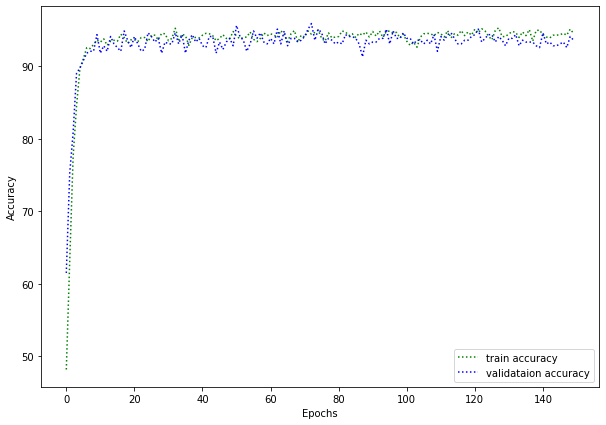

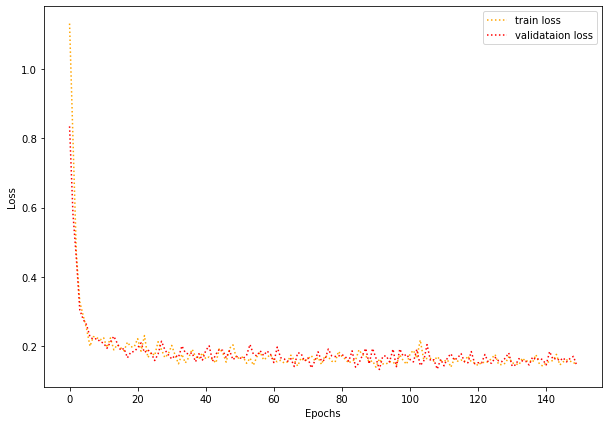

[INFO]: Epoch 1 of 50


100%|██████████| 1/1 [00:00<00:00,  3.89it/s]


K: 15, Training loss: 0.133, training acc: 94.891, epoch: 0
K: 15, Validation loss: 0.144, validation acc: 94.388, epoch: 0
--------------------------------------------------
[INFO]: Epoch 2 of 50


100%|██████████| 1/1 [00:00<00:00,  3.42it/s]


K: 15, Training loss: 0.168, training acc: 94.828, epoch: 1
K: 15, Validation loss: 0.162, validation acc: 94.133, epoch: 1
--------------------------------------------------
[INFO]: Epoch 3 of 50


100%|██████████| 1/1 [00:00<00:00,  3.54it/s]


K: 15, Training loss: 0.160, training acc: 94.764, epoch: 2
K: 15, Validation loss: 0.157, validation acc: 94.643, epoch: 2
--------------------------------------------------
[INFO]: Epoch 4 of 50


100%|██████████| 1/1 [00:00<00:00,  3.86it/s]


K: 15, Training loss: 0.133, training acc: 94.444, epoch: 3
K: 15, Validation loss: 0.186, validation acc: 94.643, epoch: 3
--------------------------------------------------
[INFO]: Epoch 5 of 50


100%|██████████| 1/1 [00:00<00:00,  3.53it/s]


K: 15, Training loss: 0.129, training acc: 94.189, epoch: 4
K: 15, Validation loss: 0.166, validation acc: 92.857, epoch: 4
--------------------------------------------------
[INFO]: Epoch 6 of 50


100%|██████████| 1/1 [00:00<00:00,  3.44it/s]


K: 15, Training loss: 0.133, training acc: 95.083, epoch: 5
K: 15, Validation loss: 0.160, validation acc: 92.602, epoch: 5
--------------------------------------------------
[INFO]: Epoch 7 of 50


100%|██████████| 1/1 [00:00<00:00,  3.64it/s]


K: 15, Training loss: 0.150, training acc: 95.083, epoch: 6
K: 15, Validation loss: 0.140, validation acc: 93.367, epoch: 6
--------------------------------------------------
[INFO]: Epoch 8 of 50


100%|██████████| 1/1 [00:00<00:00,  3.75it/s]


K: 15, Training loss: 0.150, training acc: 94.381, epoch: 7
K: 15, Validation loss: 0.164, validation acc: 93.367, epoch: 7
--------------------------------------------------
[INFO]: Epoch 9 of 50


100%|██████████| 1/1 [00:00<00:00,  3.76it/s]


K: 15, Training loss: 0.152, training acc: 93.997, epoch: 8
K: 15, Validation loss: 0.168, validation acc: 93.367, epoch: 8
--------------------------------------------------
[INFO]: Epoch 10 of 50


100%|██████████| 1/1 [00:00<00:00,  3.21it/s]


K: 15, Training loss: 0.132, training acc: 94.381, epoch: 9
K: 15, Validation loss: 0.164, validation acc: 92.092, epoch: 9
--------------------------------------------------
[INFO]: Epoch 11 of 50


100%|██████████| 1/1 [00:00<00:00,  3.76it/s]


K: 15, Training loss: 0.155, training acc: 94.891, epoch: 10
K: 15, Validation loss: 0.170, validation acc: 93.622, epoch: 10
--------------------------------------------------
[INFO]: Epoch 12 of 50


100%|██████████| 1/1 [00:00<00:00,  3.86it/s]


K: 15, Training loss: 0.156, training acc: 94.317, epoch: 11
K: 15, Validation loss: 0.160, validation acc: 92.857, epoch: 11
--------------------------------------------------
[INFO]: Epoch 13 of 50


100%|██████████| 1/1 [00:00<00:00,  4.01it/s]


K: 15, Training loss: 0.136, training acc: 95.019, epoch: 12
K: 15, Validation loss: 0.163, validation acc: 93.367, epoch: 12
--------------------------------------------------
[INFO]: Epoch 14 of 50


100%|██████████| 1/1 [00:00<00:00,  3.56it/s]


K: 15, Training loss: 0.141, training acc: 94.444, epoch: 13
K: 15, Validation loss: 0.168, validation acc: 93.622, epoch: 13
--------------------------------------------------
[INFO]: Epoch 15 of 50


100%|██████████| 1/1 [00:00<00:00,  3.88it/s]


K: 15, Training loss: 0.152, training acc: 94.828, epoch: 14
K: 15, Validation loss: 0.156, validation acc: 92.602, epoch: 14
--------------------------------------------------
[INFO]: Epoch 16 of 50


100%|██████████| 1/1 [00:00<00:00,  3.89it/s]


K: 15, Training loss: 0.171, training acc: 93.423, epoch: 15
K: 15, Validation loss: 0.154, validation acc: 92.857, epoch: 15
--------------------------------------------------
[INFO]: Epoch 17 of 50


100%|██████████| 1/1 [00:00<00:00,  3.99it/s]


K: 15, Training loss: 0.164, training acc: 94.125, epoch: 16
K: 15, Validation loss: 0.169, validation acc: 93.622, epoch: 16
--------------------------------------------------
[INFO]: Epoch 18 of 50


100%|██████████| 1/1 [00:00<00:00,  3.53it/s]


K: 15, Training loss: 0.137, training acc: 94.764, epoch: 17
K: 15, Validation loss: 0.184, validation acc: 92.092, epoch: 17
--------------------------------------------------
[INFO]: Epoch 19 of 50


100%|██████████| 1/1 [00:00<00:00,  3.87it/s]


K: 15, Training loss: 0.137, training acc: 95.466, epoch: 18
K: 15, Validation loss: 0.145, validation acc: 93.622, epoch: 18
--------------------------------------------------
[INFO]: Epoch 20 of 50


100%|██████████| 1/1 [00:00<00:00,  3.88it/s]


K: 15, Training loss: 0.128, training acc: 94.828, epoch: 19
K: 15, Validation loss: 0.152, validation acc: 93.622, epoch: 19
--------------------------------------------------
[INFO]: Epoch 21 of 50


100%|██████████| 1/1 [00:00<00:00,  3.74it/s]


K: 15, Training loss: 0.141, training acc: 94.508, epoch: 20
K: 15, Validation loss: 0.153, validation acc: 93.112, epoch: 20
--------------------------------------------------
[INFO]: Epoch 22 of 50


100%|██████████| 1/1 [00:00<00:00,  3.95it/s]


K: 15, Training loss: 0.153, training acc: 94.317, epoch: 21
K: 15, Validation loss: 0.150, validation acc: 92.602, epoch: 21
--------------------------------------------------
[INFO]: Epoch 23 of 50


100%|██████████| 1/1 [00:00<00:00,  3.65it/s]


K: 15, Training loss: 0.146, training acc: 94.636, epoch: 22
K: 15, Validation loss: 0.169, validation acc: 92.602, epoch: 22
--------------------------------------------------
[INFO]: Epoch 24 of 50


100%|██████████| 1/1 [00:00<00:00,  3.74it/s]


K: 15, Training loss: 0.153, training acc: 94.444, epoch: 23
K: 15, Validation loss: 0.145, validation acc: 93.622, epoch: 23
--------------------------------------------------
[INFO]: Epoch 25 of 50


100%|██████████| 1/1 [00:00<00:00,  3.47it/s]


K: 15, Training loss: 0.135, training acc: 94.891, epoch: 24
K: 15, Validation loss: 0.148, validation acc: 93.622, epoch: 24
--------------------------------------------------
[INFO]: Epoch 26 of 50


100%|██████████| 1/1 [00:00<00:00,  3.64it/s]


K: 15, Training loss: 0.151, training acc: 94.700, epoch: 25
K: 15, Validation loss: 0.140, validation acc: 93.367, epoch: 25
--------------------------------------------------
[INFO]: Epoch 27 of 50


100%|██████████| 1/1 [00:00<00:00,  3.79it/s]


K: 15, Training loss: 0.146, training acc: 94.700, epoch: 26
K: 15, Validation loss: 0.156, validation acc: 92.857, epoch: 26
--------------------------------------------------
[INFO]: Epoch 28 of 50


100%|██████████| 1/1 [00:00<00:00,  3.52it/s]


K: 15, Training loss: 0.148, training acc: 93.614, epoch: 27
K: 15, Validation loss: 0.164, validation acc: 93.622, epoch: 27
--------------------------------------------------
[INFO]: Epoch 29 of 50


100%|██████████| 1/1 [00:00<00:00,  3.53it/s]


K: 15, Training loss: 0.171, training acc: 94.381, epoch: 28
K: 15, Validation loss: 0.165, validation acc: 93.367, epoch: 28
--------------------------------------------------
[INFO]: Epoch 30 of 50


100%|██████████| 1/1 [00:01<00:00,  1.45s/it]


K: 15, Training loss: 0.150, training acc: 94.700, epoch: 29
K: 15, Validation loss: 0.157, validation acc: 93.367, epoch: 29
--------------------------------------------------
[INFO]: Epoch 31 of 50


100%|██████████| 1/1 [00:00<00:00,  2.60it/s]


K: 15, Training loss: 0.149, training acc: 95.019, epoch: 30
K: 15, Validation loss: 0.160, validation acc: 92.602, epoch: 30
--------------------------------------------------
[INFO]: Epoch 32 of 50


100%|██████████| 1/1 [00:00<00:00,  3.41it/s]


K: 15, Training loss: 0.145, training acc: 94.508, epoch: 31
K: 15, Validation loss: 0.166, validation acc: 93.112, epoch: 31
--------------------------------------------------
[INFO]: Epoch 33 of 50


100%|██████████| 1/1 [00:00<00:00,  3.84it/s]


K: 15, Training loss: 0.157, training acc: 93.742, epoch: 32
K: 15, Validation loss: 0.165, validation acc: 92.857, epoch: 32
--------------------------------------------------
[INFO]: Epoch 34 of 50


100%|██████████| 1/1 [00:00<00:00,  3.64it/s]


K: 15, Training loss: 0.162, training acc: 94.955, epoch: 33
K: 15, Validation loss: 0.169, validation acc: 92.602, epoch: 33
--------------------------------------------------
[INFO]: Epoch 35 of 50


100%|██████████| 1/1 [00:00<00:00,  3.76it/s]


K: 15, Training loss: 0.133, training acc: 95.211, epoch: 34
K: 15, Validation loss: 0.150, validation acc: 93.878, epoch: 34
--------------------------------------------------
[INFO]: Epoch 36 of 50


100%|██████████| 1/1 [00:00<00:00,  3.73it/s]


K: 15, Training loss: 0.139, training acc: 94.636, epoch: 35
K: 15, Validation loss: 0.135, validation acc: 93.622, epoch: 35
--------------------------------------------------
[INFO]: Epoch 37 of 50


100%|██████████| 1/1 [00:00<00:00,  3.43it/s]


K: 15, Training loss: 0.142, training acc: 94.636, epoch: 36
K: 15, Validation loss: 0.174, validation acc: 92.857, epoch: 36
--------------------------------------------------
[INFO]: Epoch 38 of 50


100%|██████████| 1/1 [00:00<00:00,  3.62it/s]


K: 15, Training loss: 0.149, training acc: 94.764, epoch: 37
K: 15, Validation loss: 0.160, validation acc: 92.602, epoch: 37
--------------------------------------------------
[INFO]: Epoch 39 of 50


100%|██████████| 1/1 [00:00<00:00,  3.77it/s]


K: 15, Training loss: 0.148, training acc: 94.955, epoch: 38
K: 15, Validation loss: 0.160, validation acc: 93.878, epoch: 38
--------------------------------------------------
[INFO]: Epoch 40 of 50


100%|██████████| 1/1 [00:00<00:00,  3.53it/s]


K: 15, Training loss: 0.163, training acc: 94.955, epoch: 39
K: 15, Validation loss: 0.172, validation acc: 93.112, epoch: 39
--------------------------------------------------
[INFO]: Epoch 41 of 50


100%|██████████| 1/1 [00:00<00:00,  3.67it/s]


K: 15, Training loss: 0.184, training acc: 94.317, epoch: 40
K: 15, Validation loss: 0.158, validation acc: 93.367, epoch: 40
--------------------------------------------------
[INFO]: Epoch 42 of 50


100%|██████████| 1/1 [00:00<00:00,  3.38it/s]


K: 15, Training loss: 0.142, training acc: 94.764, epoch: 41
K: 15, Validation loss: 0.173, validation acc: 93.112, epoch: 41
--------------------------------------------------
[INFO]: Epoch 43 of 50


100%|██████████| 1/1 [00:00<00:00,  3.74it/s]


K: 15, Training loss: 0.146, training acc: 94.381, epoch: 42
K: 15, Validation loss: 0.144, validation acc: 93.878, epoch: 42
--------------------------------------------------
[INFO]: Epoch 44 of 50


100%|██████████| 1/1 [00:00<00:00,  3.41it/s]


K: 15, Training loss: 0.146, training acc: 95.019, epoch: 43
K: 15, Validation loss: 0.167, validation acc: 92.347, epoch: 43
--------------------------------------------------
[INFO]: Epoch 45 of 50


100%|██████████| 1/1 [00:00<00:00,  3.64it/s]


K: 15, Training loss: 0.133, training acc: 95.019, epoch: 44
K: 15, Validation loss: 0.150, validation acc: 93.622, epoch: 44
--------------------------------------------------
[INFO]: Epoch 46 of 50


100%|██████████| 1/1 [00:00<00:00,  3.58it/s]


K: 15, Training loss: 0.139, training acc: 94.700, epoch: 45
K: 15, Validation loss: 0.153, validation acc: 92.857, epoch: 45
--------------------------------------------------
[INFO]: Epoch 47 of 50


100%|██████████| 1/1 [00:00<00:00,  3.52it/s]


K: 15, Training loss: 0.127, training acc: 94.764, epoch: 46
K: 15, Validation loss: 0.163, validation acc: 93.622, epoch: 46
--------------------------------------------------
[INFO]: Epoch 48 of 50


100%|██████████| 1/1 [00:00<00:00,  3.64it/s]


K: 15, Training loss: 0.144, training acc: 94.317, epoch: 47
K: 15, Validation loss: 0.156, validation acc: 93.112, epoch: 47
--------------------------------------------------
[INFO]: Epoch 49 of 50


100%|██████████| 1/1 [00:00<00:00,  3.24it/s]


K: 15, Training loss: 0.137, training acc: 94.444, epoch: 48
K: 15, Validation loss: 0.160, validation acc: 93.112, epoch: 48
--------------------------------------------------
[INFO]: Epoch 50 of 50


100%|██████████| 1/1 [00:00<00:00,  3.55it/s]


K: 15, Training loss: 0.139, training acc: 94.508, epoch: 49
K: 15, Validation loss: 0.144, validation acc: 92.857, epoch: 49
--------------------------------------------------
--------------------------------------------------
Saving final model...


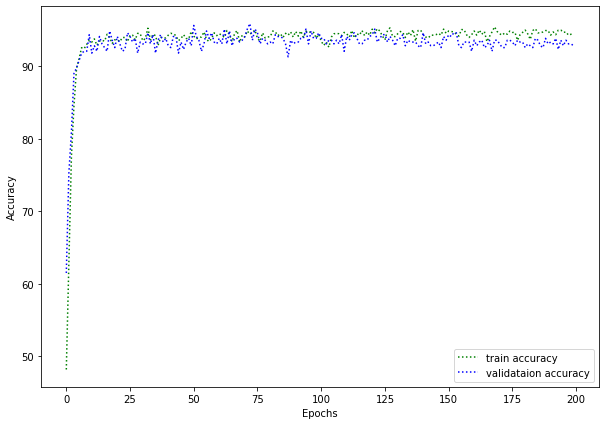

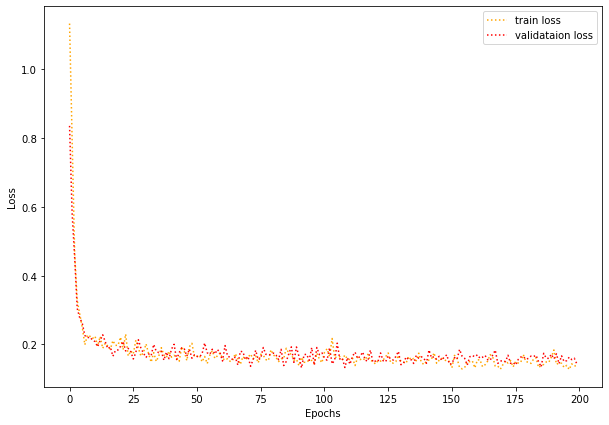

[INFO]: Epoch 1 of 50


100%|██████████| 1/1 [00:00<00:00,  2.93it/s]


K: 21, Training loss: 0.146, training acc: 93.934, epoch: 0
K: 21, Validation loss: 0.165, validation acc: 92.857, epoch: 0
--------------------------------------------------
[INFO]: Epoch 2 of 50


100%|██████████| 1/1 [00:00<00:00,  3.27it/s]


K: 21, Training loss: 0.146, training acc: 94.508, epoch: 1
K: 21, Validation loss: 0.161, validation acc: 93.112, epoch: 1
--------------------------------------------------
[INFO]: Epoch 3 of 50


100%|██████████| 1/1 [00:00<00:00,  3.15it/s]


K: 21, Training loss: 0.153, training acc: 94.508, epoch: 2
K: 21, Validation loss: 0.178, validation acc: 93.112, epoch: 2
--------------------------------------------------
[INFO]: Epoch 4 of 50


100%|██████████| 1/1 [00:00<00:00,  3.33it/s]


K: 21, Training loss: 0.151, training acc: 94.700, epoch: 3
K: 21, Validation loss: 0.138, validation acc: 93.112, epoch: 3
--------------------------------------------------
[INFO]: Epoch 5 of 50


100%|██████████| 1/1 [00:00<00:00,  3.33it/s]


K: 21, Training loss: 0.142, training acc: 94.572, epoch: 4
K: 21, Validation loss: 0.154, validation acc: 93.112, epoch: 4
--------------------------------------------------
[INFO]: Epoch 6 of 50


100%|██████████| 1/1 [00:00<00:00,  3.43it/s]


K: 21, Training loss: 0.145, training acc: 94.764, epoch: 5
K: 21, Validation loss: 0.161, validation acc: 93.112, epoch: 5
--------------------------------------------------
[INFO]: Epoch 7 of 50


100%|██████████| 1/1 [00:00<00:00,  2.91it/s]


K: 21, Training loss: 0.139, training acc: 94.955, epoch: 6
K: 21, Validation loss: 0.151, validation acc: 93.367, epoch: 6
--------------------------------------------------
[INFO]: Epoch 8 of 50


100%|██████████| 1/1 [00:00<00:00,  3.34it/s]


K: 21, Training loss: 0.141, training acc: 94.764, epoch: 7
K: 21, Validation loss: 0.145, validation acc: 92.857, epoch: 7
--------------------------------------------------
[INFO]: Epoch 9 of 50


100%|██████████| 1/1 [00:00<00:00,  3.23it/s]


K: 21, Training loss: 0.136, training acc: 94.508, epoch: 8
K: 21, Validation loss: 0.149, validation acc: 93.367, epoch: 8
--------------------------------------------------
[INFO]: Epoch 10 of 50


100%|██████████| 1/1 [00:00<00:00,  2.80it/s]


K: 21, Training loss: 0.135, training acc: 94.572, epoch: 9
K: 21, Validation loss: 0.151, validation acc: 92.857, epoch: 9
--------------------------------------------------
[INFO]: Epoch 11 of 50


100%|██████████| 1/1 [00:00<00:00,  3.32it/s]


K: 21, Training loss: 0.143, training acc: 94.381, epoch: 10
K: 21, Validation loss: 0.146, validation acc: 93.622, epoch: 10
--------------------------------------------------
[INFO]: Epoch 12 of 50


100%|██████████| 1/1 [00:00<00:00,  3.32it/s]


K: 21, Training loss: 0.128, training acc: 94.636, epoch: 11
K: 21, Validation loss: 0.144, validation acc: 92.857, epoch: 11
--------------------------------------------------
[INFO]: Epoch 13 of 50


100%|██████████| 1/1 [00:00<00:00,  3.26it/s]


K: 21, Training loss: 0.136, training acc: 94.636, epoch: 12
K: 21, Validation loss: 0.147, validation acc: 93.367, epoch: 12
--------------------------------------------------
[INFO]: Epoch 14 of 50


100%|██████████| 1/1 [00:00<00:00,  3.25it/s]


K: 21, Training loss: 0.131, training acc: 94.891, epoch: 13
K: 21, Validation loss: 0.153, validation acc: 92.857, epoch: 13
--------------------------------------------------
[INFO]: Epoch 15 of 50


100%|██████████| 1/1 [00:00<00:00,  3.34it/s]


K: 21, Training loss: 0.134, training acc: 95.147, epoch: 14
K: 21, Validation loss: 0.145, validation acc: 93.112, epoch: 14
--------------------------------------------------
[INFO]: Epoch 16 of 50


100%|██████████| 1/1 [00:00<00:00,  3.46it/s]


K: 21, Training loss: 0.137, training acc: 94.891, epoch: 15
K: 21, Validation loss: 0.152, validation acc: 93.367, epoch: 15
--------------------------------------------------
[INFO]: Epoch 17 of 50


100%|██████████| 1/1 [00:00<00:00,  3.17it/s]


K: 21, Training loss: 0.136, training acc: 94.572, epoch: 16
K: 21, Validation loss: 0.153, validation acc: 92.857, epoch: 16
--------------------------------------------------
[INFO]: Epoch 18 of 50


100%|██████████| 1/1 [00:00<00:00,  3.28it/s]


K: 21, Training loss: 0.141, training acc: 94.381, epoch: 17
K: 21, Validation loss: 0.156, validation acc: 93.112, epoch: 17
--------------------------------------------------
[INFO]: Epoch 19 of 50


100%|██████████| 1/1 [00:00<00:00,  3.12it/s]


K: 21, Training loss: 0.133, training acc: 94.444, epoch: 18
K: 21, Validation loss: 0.143, validation acc: 93.622, epoch: 18
--------------------------------------------------
[INFO]: Epoch 20 of 50


100%|██████████| 1/1 [00:00<00:00,  2.72it/s]


K: 21, Training loss: 0.150, training acc: 94.508, epoch: 19
K: 21, Validation loss: 0.145, validation acc: 92.857, epoch: 19
--------------------------------------------------
[INFO]: Epoch 21 of 50


100%|██████████| 1/1 [00:00<00:00,  2.93it/s]


K: 21, Training loss: 0.141, training acc: 94.955, epoch: 20
K: 21, Validation loss: 0.136, validation acc: 93.878, epoch: 20
--------------------------------------------------
[INFO]: Epoch 22 of 50


100%|██████████| 1/1 [00:00<00:00,  3.42it/s]


K: 21, Training loss: 0.139, training acc: 94.381, epoch: 21
K: 21, Validation loss: 0.141, validation acc: 93.112, epoch: 21
--------------------------------------------------
[INFO]: Epoch 23 of 50


100%|██████████| 1/1 [00:00<00:00,  2.28it/s]


K: 21, Training loss: 0.134, training acc: 94.572, epoch: 22
K: 21, Validation loss: 0.151, validation acc: 92.347, epoch: 22
--------------------------------------------------
[INFO]: Epoch 24 of 50


100%|██████████| 1/1 [00:00<00:00,  3.29it/s]


K: 21, Training loss: 0.131, training acc: 94.828, epoch: 23
K: 21, Validation loss: 0.163, validation acc: 92.857, epoch: 23
--------------------------------------------------
[INFO]: Epoch 25 of 50


100%|██████████| 1/1 [00:00<00:00,  3.33it/s]


K: 21, Training loss: 0.132, training acc: 94.700, epoch: 24
K: 21, Validation loss: 0.139, validation acc: 93.112, epoch: 24
--------------------------------------------------
[INFO]: Epoch 26 of 50


100%|██████████| 1/1 [00:00<00:00,  2.94it/s]


K: 21, Training loss: 0.141, training acc: 95.083, epoch: 25
K: 21, Validation loss: 0.156, validation acc: 92.602, epoch: 25
--------------------------------------------------
[INFO]: Epoch 27 of 50


100%|██████████| 1/1 [00:00<00:00,  2.91it/s]


K: 21, Training loss: 0.134, training acc: 95.019, epoch: 26
K: 21, Validation loss: 0.138, validation acc: 93.622, epoch: 26
--------------------------------------------------
[INFO]: Epoch 28 of 50


100%|██████████| 1/1 [00:00<00:00,  3.16it/s]


K: 21, Training loss: 0.140, training acc: 94.508, epoch: 27
K: 21, Validation loss: 0.137, validation acc: 93.112, epoch: 27
--------------------------------------------------
[INFO]: Epoch 29 of 50


100%|██████████| 1/1 [00:00<00:00,  3.31it/s]


K: 21, Training loss: 0.141, training acc: 94.125, epoch: 28
K: 21, Validation loss: 0.154, validation acc: 92.857, epoch: 28
--------------------------------------------------
[INFO]: Epoch 30 of 50


100%|██████████| 1/1 [00:00<00:00,  3.11it/s]


K: 21, Training loss: 0.146, training acc: 94.764, epoch: 29
K: 21, Validation loss: 0.153, validation acc: 93.112, epoch: 29
--------------------------------------------------
[INFO]: Epoch 31 of 50


100%|██████████| 1/1 [00:00<00:00,  3.08it/s]


K: 21, Training loss: 0.133, training acc: 94.572, epoch: 30
K: 21, Validation loss: 0.156, validation acc: 92.857, epoch: 30
--------------------------------------------------
[INFO]: Epoch 32 of 50


100%|██████████| 1/1 [00:00<00:00,  2.67it/s]


K: 21, Training loss: 0.138, training acc: 94.572, epoch: 31
K: 21, Validation loss: 0.139, validation acc: 93.622, epoch: 31
--------------------------------------------------
[INFO]: Epoch 33 of 50


100%|██████████| 1/1 [00:00<00:00,  3.02it/s]


K: 21, Training loss: 0.138, training acc: 94.955, epoch: 32
K: 21, Validation loss: 0.145, validation acc: 92.857, epoch: 32
--------------------------------------------------
[INFO]: Epoch 34 of 50


100%|██████████| 1/1 [00:00<00:00,  3.23it/s]


K: 21, Training loss: 0.133, training acc: 94.891, epoch: 33
K: 21, Validation loss: 0.153, validation acc: 93.367, epoch: 33
--------------------------------------------------
[INFO]: Epoch 35 of 50


100%|██████████| 1/1 [00:00<00:00,  2.92it/s]


K: 21, Training loss: 0.130, training acc: 94.508, epoch: 34
K: 21, Validation loss: 0.151, validation acc: 92.602, epoch: 34
--------------------------------------------------
[INFO]: Epoch 36 of 50


100%|██████████| 1/1 [00:00<00:00,  3.33it/s]


K: 21, Training loss: 0.140, training acc: 94.572, epoch: 35
K: 21, Validation loss: 0.145, validation acc: 93.367, epoch: 35
--------------------------------------------------
[INFO]: Epoch 37 of 50


100%|██████████| 1/1 [00:00<00:00,  2.94it/s]


K: 21, Training loss: 0.141, training acc: 94.891, epoch: 36
K: 21, Validation loss: 0.156, validation acc: 93.367, epoch: 36
--------------------------------------------------
[INFO]: Epoch 38 of 50


100%|██████████| 1/1 [00:00<00:00,  3.17it/s]


K: 21, Training loss: 0.132, training acc: 94.636, epoch: 37
K: 21, Validation loss: 0.141, validation acc: 93.367, epoch: 37
--------------------------------------------------
[INFO]: Epoch 39 of 50


100%|██████████| 1/1 [00:00<00:00,  3.24it/s]


K: 21, Training loss: 0.141, training acc: 94.508, epoch: 38
K: 21, Validation loss: 0.149, validation acc: 93.622, epoch: 38
--------------------------------------------------
[INFO]: Epoch 40 of 50


100%|██████████| 1/1 [00:00<00:00,  3.24it/s]


K: 21, Training loss: 0.137, training acc: 94.508, epoch: 39
K: 21, Validation loss: 0.140, validation acc: 92.857, epoch: 39
--------------------------------------------------
[INFO]: Epoch 41 of 50


100%|██████████| 1/1 [00:00<00:00,  3.28it/s]


K: 21, Training loss: 0.130, training acc: 94.955, epoch: 40
K: 21, Validation loss: 0.148, validation acc: 93.112, epoch: 40
--------------------------------------------------
[INFO]: Epoch 42 of 50


100%|██████████| 1/1 [00:00<00:00,  3.16it/s]


K: 21, Training loss: 0.129, training acc: 94.381, epoch: 41
K: 21, Validation loss: 0.138, validation acc: 93.112, epoch: 41
--------------------------------------------------
[INFO]: Epoch 43 of 50


100%|██████████| 1/1 [00:00<00:00,  3.18it/s]


K: 21, Training loss: 0.147, training acc: 94.508, epoch: 42
K: 21, Validation loss: 0.145, validation acc: 93.367, epoch: 42
--------------------------------------------------
[INFO]: Epoch 44 of 50


100%|██████████| 1/1 [00:00<00:00,  2.90it/s]


K: 21, Training loss: 0.155, training acc: 94.700, epoch: 43
K: 21, Validation loss: 0.155, validation acc: 92.857, epoch: 43
--------------------------------------------------
[INFO]: Epoch 45 of 50


100%|██████████| 1/1 [00:00<00:00,  3.45it/s]


K: 21, Training loss: 0.127, training acc: 94.764, epoch: 44
K: 21, Validation loss: 0.154, validation acc: 92.857, epoch: 44
--------------------------------------------------
[INFO]: Epoch 46 of 50


100%|██████████| 1/1 [00:00<00:00,  3.43it/s]


K: 21, Training loss: 0.136, training acc: 94.955, epoch: 45
K: 21, Validation loss: 0.142, validation acc: 93.112, epoch: 45
--------------------------------------------------
[INFO]: Epoch 47 of 50


100%|██████████| 1/1 [00:00<00:00,  3.52it/s]


K: 21, Training loss: 0.135, training acc: 94.764, epoch: 46
K: 21, Validation loss: 0.153, validation acc: 93.112, epoch: 46
--------------------------------------------------
[INFO]: Epoch 48 of 50


100%|██████████| 1/1 [00:00<00:00,  3.60it/s]


K: 21, Training loss: 0.129, training acc: 95.211, epoch: 47
K: 21, Validation loss: 0.147, validation acc: 93.112, epoch: 47
--------------------------------------------------
[INFO]: Epoch 49 of 50


100%|██████████| 1/1 [00:00<00:00,  3.33it/s]


K: 21, Training loss: 0.129, training acc: 94.891, epoch: 48
K: 21, Validation loss: 0.147, validation acc: 92.602, epoch: 48
--------------------------------------------------
[INFO]: Epoch 50 of 50


100%|██████████| 1/1 [00:00<00:00,  2.45it/s]


K: 21, Training loss: 0.141, training acc: 95.019, epoch: 49
K: 21, Validation loss: 0.150, validation acc: 92.857, epoch: 49
--------------------------------------------------
--------------------------------------------------
Saving final model...


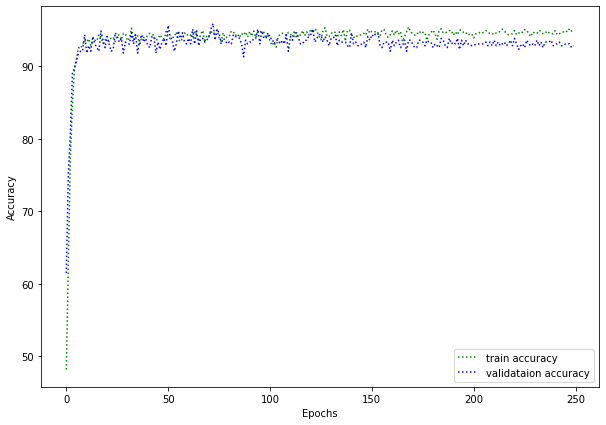

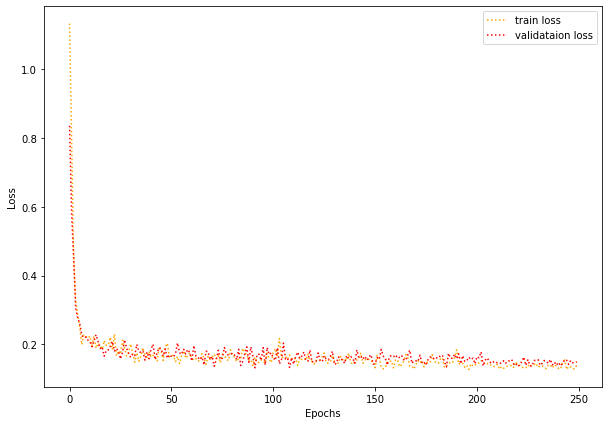

TRAINING COMPLETE


In [182]:
train_val()

In [185]:
# Test the model on test samples

confusion_matrix = torch.zeros(NUM_CLASSES, NUM_CLASSES)
k_list = [3, 5, 7, 11, 21]
for k in k_list:
    print("K = ",k)
    model_gat.eval()
    with torch.no_grad():
        for i, (inputs, classes) in enumerate(test_loader):
            inputs = inputs.to(device)
            classes = classes.to(device)
            adj = nearestneighbours(inputs, k)
            edge = edge_finder(adj)
            out = model_gat(inputs.squeeze(), edge)
            label = classes.to(torch.long)
            loss = criterion(out, label)
            #print(outputs)
            fl_pred = out.argmax(dim=1)
            #print(confusion_matrix(classes, fl_pred))
            p=precision_score(classes.cpu(), fl_pred.cpu(), average="micro", zero_division= False)
            r=recall_score(classes.cpu(), fl_pred.cpu(), average="micro", zero_division= False)
            f=f1_score(classes.cpu(), fl_pred.cpu(), average="micro", zero_division= False)
            print('F1: {}'.format(f))
            print('Precision: {}'.format(p))
            print('Recall: {}'.format(r))
            print(classification_report(classes.cpu(),fl_pred.cpu()))

K =  3
F1: 0.946
Precision: 0.946
Recall: 0.946
              precision    recall  f1-score   support

           0       0.96      0.93      0.95       250
           1       0.93      0.96      0.95       250

    accuracy                           0.95       500
   macro avg       0.95      0.95      0.95       500
weighted avg       0.95      0.95      0.95       500

K =  5
F1: 0.948
Precision: 0.948
Recall: 0.948
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       250
           1       0.94      0.96      0.95       250

    accuracy                           0.95       500
   macro avg       0.95      0.95      0.95       500
weighted avg       0.95      0.95      0.95       500

K =  7
F1: 0.952
Precision: 0.952
Recall: 0.952
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       250
           1       0.94      0.96      0.95       250

    accuracy                          

In [57]:
print(confusion_matrix.diag().sum()/confusion_matrix.sum())

tensor(nan)


K =  3
Accuracy on test data: 0.952
Precison:  0.952
Recall:  0.952
F1-Score : 0.952


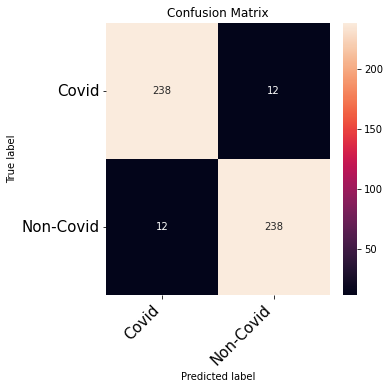

K =  5
Accuracy on test data: 0.946
Precison:  0.964
Recall:  0.9198473282442748
F1-Score : 0.94140625


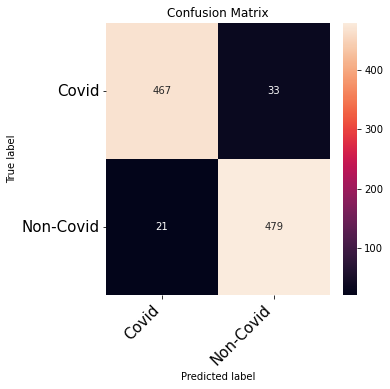

K =  7
Accuracy on test data: 0.948
Precison:  0.968
Recall:  0.937984496124031
F1-Score : 0.952755905511811


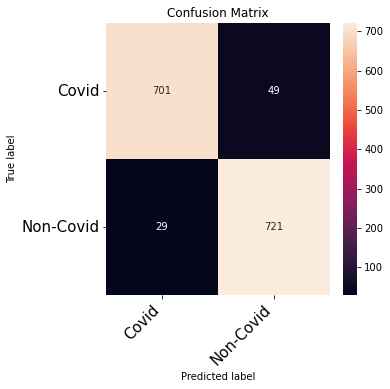

K =  9
Accuracy on test data: 0.9505
Precison:  0.968
Recall:  0.9490196078431372
F1-Score : 0.9584158415841584


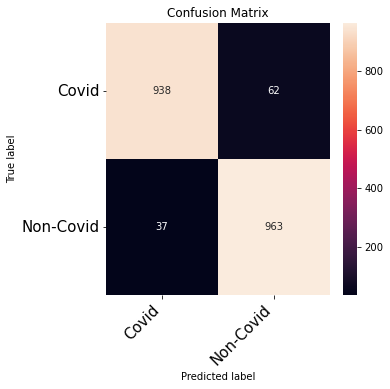

K =  11
Accuracy on test data: 0.9524
Precison:  0.968
Recall:  0.952755905511811
F1-Score : 0.9603174603174602


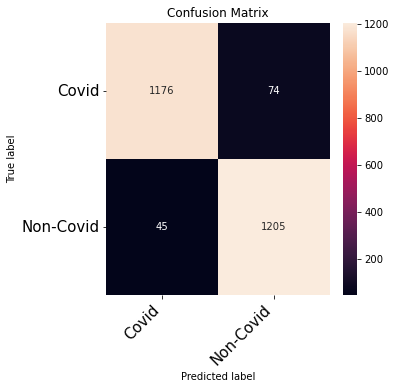

K =  15
Accuracy on test data: 0.9526666666666667
Precison:  0.952
Recall:  0.9558232931726908
F1-Score : 0.9539078156312626


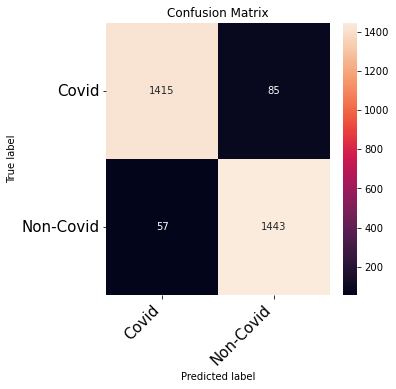

K =  21
Accuracy on test data: 0.9522857142857143
Precison:  0.952
Recall:  0.9482071713147411
F1-Score : 0.9500998003992016


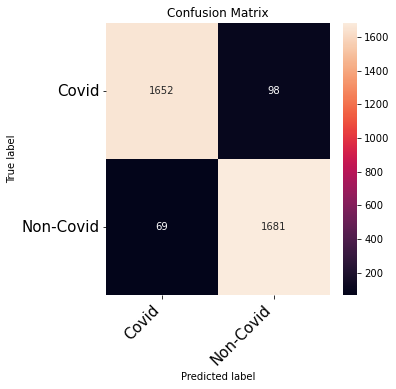

In [186]:
import seaborn as sns
import numpy as np
import pandas as pd
confusion_matrix = np.zeros((NUM_CLASSES, NUM_CLASSES))
k_list = [3, 5, 7,9,11,15,21]
for k in k_list:
    print("K = ",k)
    model_gat.eval()
    with torch.no_grad():
        for i, (inputs, classes) in enumerate(test_loader):
            inputs = inputs.to(device)
            classes = classes.to(device)
            adj_matrix = nearestneighbours(inputs,k)
            adj_matrix = adj_matrix.to(device)
            edge = edge_finder(adj_matrix)
            outputs = model_gat(inputs.squeeze(),edge)
            _, preds = torch.max(outputs, 1)
            for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1
                
    print(f"Accuracy on test data: {confusion_matrix.diagonal().sum()/confusion_matrix.sum()}")
    print("Precison: ", precision_score(preds, classes))
    print("Recall: ",recall_score(preds, classes))
    print("F1-Score :", f1_score(preds, classes))
    plt.figure(figsize=(5,5))

    class_names = ['Covid','Non-Covid']
    df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names).astype(int)
    heatmap = sns.heatmap(df_cm, annot=True, fmt="d")

    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=15)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title('Confusion Matrix')
    plt.show()

In [ ]:
torch.save(model_gat,'GATv1.pth')

### t-SNE Embedding

In [ ]:
df_features = pd.DataFrame(tsne_features) #convert to a dataframe
df_features.to_csv("tsne_features_data",index=False) #save to file

#Then, to reload:
df_features = pd.read_csv("tsne_features_data")

In [ ]:
df_features.tail()

In [ ]:
df_labels = pd.DataFrame(tsne_labels) #convert to a dataframe
df_labels.to_csv("tsne_labels_data",index=False) #save to file

#Then, to reload:
df_labels = pd.read_csv("tsne_labels_data")
df_labels.head()

In [ ]:
df_labels.tail()

In [ ]:
df = pd.concat([df_features,df_labels],axis=1)

In [ ]:
df.tail()

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sn
from sklearn.manifold import TSNE

In [ ]:
# TSNE
# Picking the top 1000 points as TSNE
# takes a lot of time for 15K points

 
tsne_model = TSNE(n_components = 2, random_state = 0,learning_rate='auto',
                  init='random')
# configuring the parameters
# the number of components = 2
# default perplexity = 30
# default learning rate = 200
# default Maximum number of iterations
# for the optimization = 1000
 
tsne_data = tsne_model.fit_transform(df_features, df_labels)
 
# creating a new data frame which
# help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, tsne_labels)).T
tsne_df = pd.DataFrame(data = tsne_data, columns =("Dim_1", "Dim_2", "label"))
 
# Ploting the result of tsne
sn.FacetGrid(tsne_df, hue ="label", size = 6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()
 

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

# Split into training and test set
X_train, X_test, y_train, y_test = train_test_split(
             df_features, df_labels, test_size = 0.2, random_state=42)
 
knn = KNeighborsClassifier(n_neighbors=7)
 
model = knn.fit(X_train, y_train)
 
# Predict on dataset which model has not seen before
#pred = knn.predict(X_test)
#print(knn.score(X_test, y_test))

In [ ]:
X_train.shape

In [ ]:
A = knn.kneighbors_graph(X_train)
A.toarray()

In [ ]:
torch.save(A,'adjacency_matrix.pth')

In [ ]:
A.shape

In [ ]:
import scipy

In [ ]:
cx = scipy.sparse.coo_matrix(A)
edges = []
for i,j,v in zip(cx.row, cx.col, cx.data):
    edges.append([i,j])
    

In [ ]:
edges

In [ ]:
torch.save(edges,'edges.pth')

In [ ]:
import networkx as nx

In [ ]:
!pip install geoopt

In [ ]:
from geoopt.manifolds import PoincareBall

In [ ]:
from geoopt.manifolds import stereographic as st

In [ ]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt

def norm(x, axis=None):
    return np.linalg.norm(x, axis=axis)

def poincare_dist(u, v, eps=1e-5):
    d = 1 + 2 * norm(u-v)**2 / ((1 - norm(u)**2) * (1 - norm(v)**2) + eps)
    return np.arctanh(d)

In [ ]:
dist = []
for i in range(445):
    poin_dist = poincare_dist(X_train[:1],X_train[i:i+1:])
    dist.append(poin_dist)
print(dist)